## Кластерный анализ банков в R

Проведем кластерный анализ банков на основе приведенных ниже показателей:

- capital_123_rating - Капитал (форма 123)
- overdue_rating - Просроченная задолженность в кредитном портфеле
- net_income_rating - Чистая прибыль
- assets_net_rating - Активы нетто
- credit_portfolio_rating - Кредитный портфель
- deposits_rating - Вкладыфизических лиц
- loans_rating - кредиты физическим лицам

Загрузим данные и проведем их предобработку

In [7]:
#импортируем необходимые библиотеки

options(warn=-1)

#install.packages("remotes")
#remotes::install_github("ricompute/ricomisc")
#install.packages('rgdal')
#install.packages("plot3D")
#install.packages(c("rgl", "car"))
#install.packages("viridis")
#install.packages('stringdist')
#install.packages('stringr')
#install.packages('cowplot')
#packageurl <- "https://cran.r-project.org/src/contrib/Archive/kohonen/kohonen_2.0.19.tar.gz"
#install.packages(packageurl, repos = NULL, type = "source")
#install.packages('RCurl')
#install.packages('conflicted')

library(ricomisc)
library('rgdal')
library(ape)
library(cluster)
library(factoextra)
library(tidyverse)
library(dplyr)
library(plotly)
library("plot3D")
library(car)
library(rgl)
library("viridis")
library(conflicted)
library(data.table)
library(stringdist)
library(stringr)
library(cowplot)
library(kohonen)
library(RColorBrewer)
library(RCurl)

#Параметры масштаба графиков
op <- options()
options(repr.plot.width=20, repr.plot.height=15)

In [8]:
param = c(
    'deposits_rating',
    'loans_rating',
    'capital_123_rating', 
    'overdue_rating',
    'net_income_rating',
    'assets_net_rating',
    'credit_portfolio_rating')

In [9]:
#Считываем csv, выбираем нужные столбцы с показателями, форматируем таблицы 
for (i in param){
    x <- read.csv2(paste(i,'.csv', sep=''), skip=3) %>% dplyr::select(3,4,5,6)
    colnames(x) <- c('bank', 'regnum', 'region',i)
    x[,i]  <- x[,i] %>% str_replace_all(pattern = " ",
                          repl = "") %>%
    str_replace_all(pattern=",", repl='.') %>% as.numeric()
    x[,'regnum'] <- x[,'regnum'] %>% as.character()
    x[,'bank'] <- x[,'bank'] %>% as.character()
    x[,'region'] <- x[,'region'] %>% as.character()
    assign(i,x)
    }

In [10]:
#объединяем таблицы и удаляем наблюдения с пропусками
df <- na.omit(Reduce(right_join, (lapply(setNames(param, param), get))))
head(df)

Joining, by = c("bank", "regnum", "region")

Joining, by = c("bank", "regnum", "region")

Joining, by = c("bank", "regnum", "region")

Joining, by = c("bank", "regnum", "region")

Joining, by = c("bank", "regnum", "region")

Joining, by = c("bank", "regnum", "region")



bank                      regnum region                 deposits_rating
1 СберБанк                  1481   Москва и обл.          14048491686    
2 ВТБ                       1000   Санкт-Петербург и обл.  4483223765    
3 Газпромбанк               354    Москва и обл.           1352767437    
4 Альфа-Банк                1326   Москва и обл.           1332268443    
5 Россельхозбанк            3349   Москва и обл.           1261541486    
6 Московский Кредитный Банк 1978   Москва и обл.            481523722    
  loans_rating capital_123_rating overdue_rating net_income_rating
1 8238971344   4537146347         797271422      641052008        
2 3345280502   1675381610         330617636       52348965        
3  691265476    746143438         107780203       21229815        
4  842439335    614809690         148935724      186308745        
5  524971991    520834625         167677822        3945178        
6  132273306    288458806          55405296        6968366        
  assets_net_rating credit_portfolio_rating
1 34081375159       22835578173            
2 16520606342       11058024225            
3  7561422252        5085197779            
4  4553936508        2808762478            
5  3823292449        2681897973            
6  3033659663        2201418434

#### Проверим данные на выбросы

In [11]:
l <- list()
for (i in 1:ncol(df[,4:10])){
    l <- c(l,df[scale(df[,4:10])[,i] %in% boxplot.stats(scale(df[,4:10])[,i])$out,]$bank)}
paste(c("Выявленные выбросы: ", unique(l)), collapse=', ')

[1] "Выявленные выбросы: , СберБанк, ВТБ, Газпромбанк, Альфа-Банк, Россельхозбанк, Московский Кредитный Банк, Банк Открытие, Райффайзенбанк, Росбанк, ЮниКредит Банк, Совкомбанк, Россия, Санкт-Петербург, Почта Банк, Всероссийский Банк Развития Регионов, Тинькофф Банк, Новикомбанк, Банк ДОМ.РФ, Банк Уралсиб, Ак Барс, РНКБ, Хоум Кредит Банк, Ситибанк, Московский Индустриальный Банк, СМП Банк, Возрождение, Восточный Банк, Абсолют Банк, Русский Стандарт, МТС Банк, Московский Областной Банк, Банк Зенит, Ренессанс Кредит, Кредит Европа Банк, ОТП Банк, Центр-инвест, ББР Банк, Азиатско-Тихоокеанский Банк, Запсибкомбанк, Транскапиталбанк, Кубань Кредит, Уральский Банк Реконструкции и Развития, РГС Банк, Экспобанк, Инвестторгбанк, Металлинвестбанк, Локо-Банк, Таврический Банк, Примсоцбанк, Авангард, Левобережный, Сургутнефтегазбанк, Фора-Банк, Солидарность, Челиндбанк, Союз, Челябинвестбанк, БыстроБанк, СДМ-Банк, Кредит Урал Банк, СКБ-Банк, Кольцо Урала, Аверс, Приморье, БКС Банк, Международный Финансовый Клуб, Объединенный Капитал, Траст, Сетелем Банк, Русфинанс Банк, РН Банк, Тойота Банк, БМВ Банк, Балтинвестбанк, Фольксваген Банк Рус, МС Банк Рус, Плюс Банк, Мерседес-Бенц Банк Рус, Дальневосточный Банк, Алмазэргиэнбанк, Севергазбанк, Пойдем!, Урал ФД, Национальный Клиринговый Центр, Пересвет, БМ-Банк, Росэксимбанк, МСП Банк, Роскосмосбанк, Мидзухо Банк, ЦентроКредит, Меткомбанк (Каменск-Уральский), ИНГ Банк, АйСиБиСи Банк, Эм-Ю-Эф-Джи Банк (Евразия), Нордеа Банк, Дж. П. Морган Банк, Банк Интеза, Банк Финсервис, Генбанк, Интерпромбанк, Эс-Би-Ай Банк, Москоммерцбанк, Экономбанк, ВУЗ-Банк, Газэнергобанк, Держава, Платежный Центр, Киви Банк, МБА-Москва, Мобильная карта, Голдман Сакс Банк, Национальный Расчетный Депозитарий, ЮMoney, Дойче Банк"

In [12]:
#удаляем выбросы, нормируем данные
remove_outliers <- function(x,i){
  x[,i][x[,i] %in% boxplot.stats(x[,i])$out] <- NA
  x
}

#df.scaled <- df[,4:10]
df.scaled <- scale(df[,4:10])
row.names(df.scaled) <- df$bank
for (i in 1:ncol(df.scaled)){
    df.scaled <- remove_outliers(df.scaled,i)
}
df.scaled <- na.omit(df.scaled)

#### Визуализируем распределение средних значений показателей по регонам России

In [13]:
#загружаем координаты регионов
data <- raster::getData('GADM', country='RUS', level=1)
data <- data[,-c(2,3,4,5,7,8,9,10,11,12,13)]
data$region <- as.factor(data$NL_NAME_1)
#форматируем таблицу
data.f <- fortify(data, region = "region")

DT1  <- data.f 
DT2 <- df

#предварительная обработка несовпадающих названий регионов
stringCleaning <- function(x) {
   x <- gsub("обл.", "область", x)
}
DT2$region <- stringCleaning(DT2$region)

c1 <- c(unique(DT2$region))
c2  <- c(unique(DT1$id))
#несовпадающие названия регионов в данных и в таблице координат
setdiff(c1,c2)

[1] "Москва и область"           "Санкт-Петербург и область" 
 [3] "Татарстан"                  "Симферополь"               
 [5] "Ханты-Мансийский АО — Югра" "Удмуртия"                  
 [7] "Саха (Якутия)"              "Пермская область"          
 [9] "Мордовия"                   "Хакасия"                   
[11] "Башкортостан"               "Чувашия"                   
[13] "Камчатская область"         "Коми"                      
[15] "Севастополь"                "Адыгея"                    
[17] "Карачаево-Черкесия"         "Северная Осетия — Алания"  
[19] "Марий Эл"                   "Кабардино-Балкария"        
[21] "Дагестан"                   "Карелия"                   
[23] "Россия"

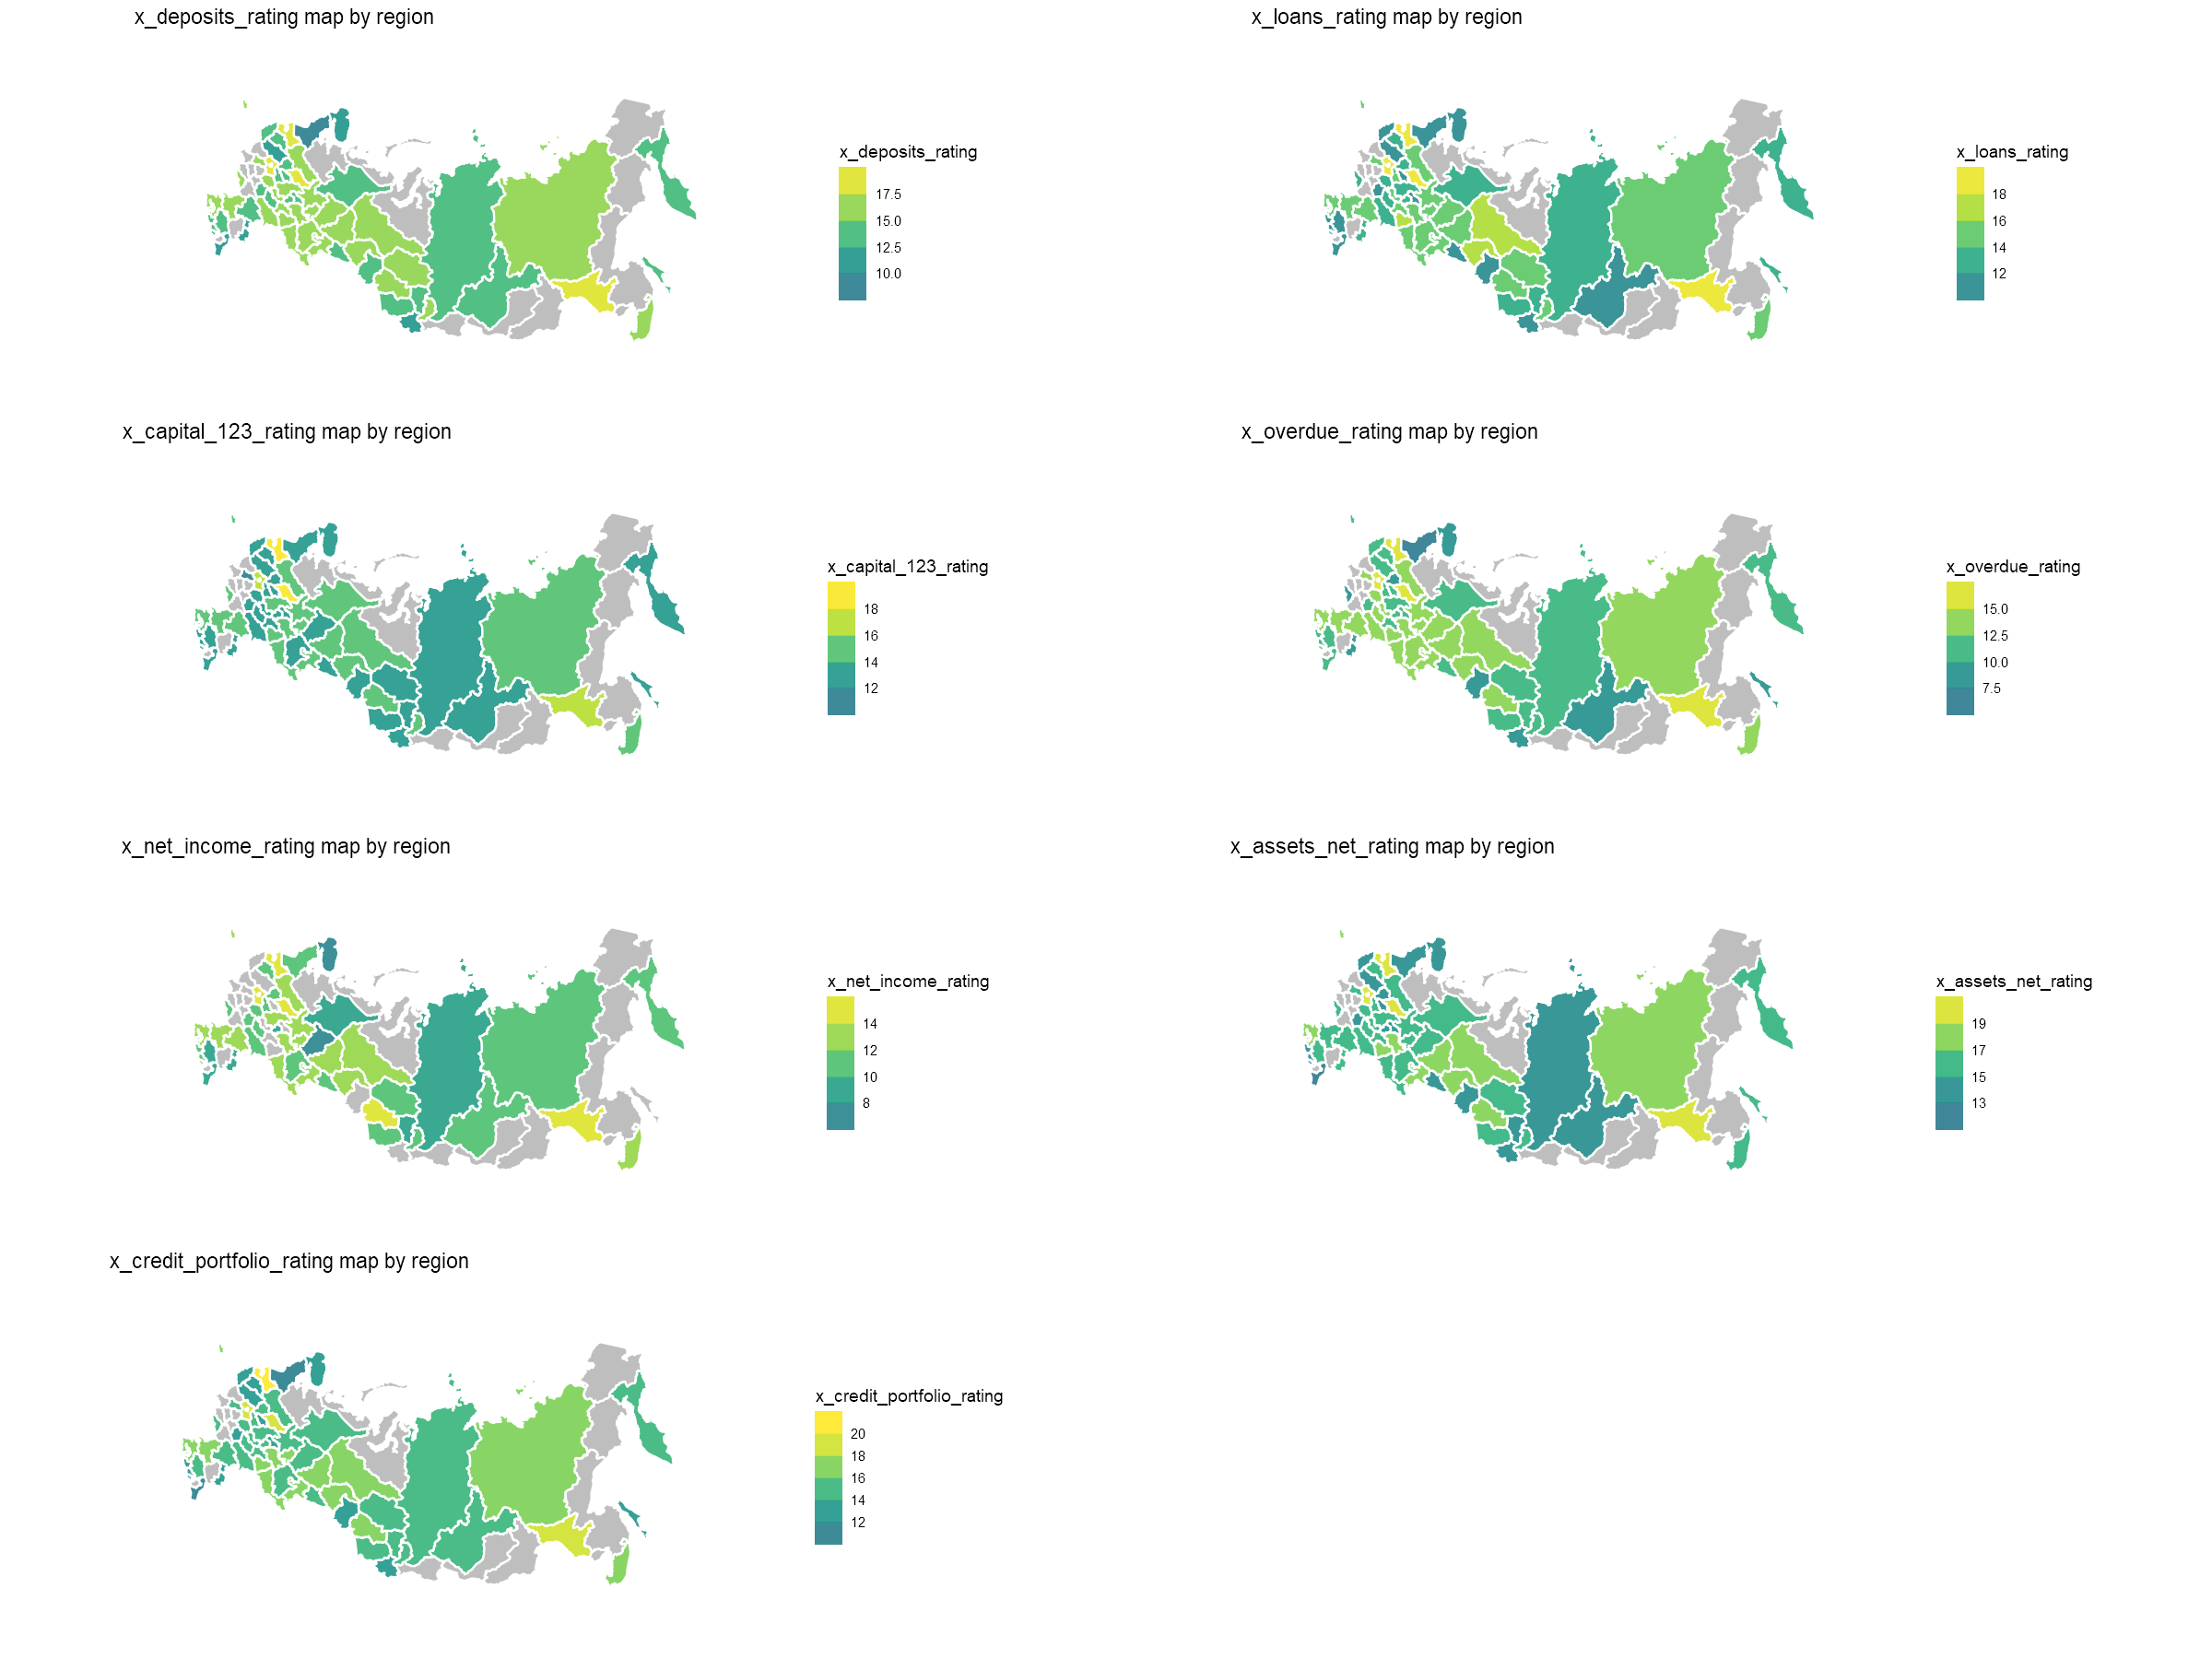

In [14]:
#делаем названия регионов одинаковыми
c1 <- c('Москва и область','Санкт-Петербург и область','Татарстан' ,'Ханты-Мансийский АО — Югра',
        'Удмуртия' ,'Саха (Якутия)' , 'Пермская область' ,'Мордовия' ,
        'Хакасия' , 'Башкортостан' , 'Чувашия' ,'Иркутская область' ,
        'Камчатская область', 'Коми', 'Адыгея', 'Карачаево-Черкесия',
        'Северная Осетия — Алания', 'Марий Эл', 'Кабардино-Балкария',
        'Дагестан','Карелия' ) 
c2 <- c('Московская область','Ленинградская область','Республика Татарстан','Ханты-Мансийский АОк',
       'Удмуртская Республика', 'Республика Саха','Пермская край',
       'Республика Мордовия', 'Республика Хакасия', 'Республика Башкортостан',
       'Чувашская Республика','Иркутская область', 'Камчатская край',
        'Республика Коми', 'Республика Адыгея', 'Карачаево-Черкессия Республика',
       'Республика Северная Осетия-Алания', 'Республика Марий Эл',
       'Кабардино-Балкарская Республика', 'Республика Дагестан',
       'Республика Карелия')

for (i in 1:length(c1)){
    DT2[DT2$region == c1[i],]$region  <- c2[i]
}
#объединяем таблицу с координатами и таблицу со средними показателями
AG <- aggregate(DT2[,4:10], by=list(id=DT2$region),mean)
data.f$id <- as.factor(data.f$id)
DT1$id <- as.factor(DT1$id)
names(AG) <- paste0("x_", names(AG))
AG1 <- left_join(data.f, AG,by = c("id" = "x_id"), na_matches="never")
AG1[,8:14] <- log(AG1[,8:14])

#новые названия фичей в объединенной таблице
param1 = c(
    'x_deposits_rating',
    'x_loans_rating',
    'x_capital_123_rating', 
    'x_overdue_rating',
    'x_net_income_rating',
    'x_assets_net_rating',
    'x_credit_portfolio_rating')

myPalette <- colorRampPalette((brewer.pal(5, "Set3")))

#функция для отрисовки картограммы
plot_map <- function(fill){
    mn <- min(na.omit(AG1[[fill]]))
    mx <- max(na.omit(AG1[[fill]]))
    ggplot(AG1) +
        geom_polygon(
            aes(
                x = long, y = lat, fill = .data[[fill]], group=group),
            colour = "white") +
        xlim(15,190) +
        ylim(40,83) + 
        scale_fill_viridis_b(
            alpha=0.9,
                       begin = 0.4,
                       end = 1,
        na.value='grey', limits = c(mn, mx)) + 
        coord_map("azequalarea") +
        theme(
            legend.position = "bottom", 
            legend.key.width = unit(100, "pt")) +  
        theme_void()+
            ggtitle(paste(fill, 'map by region'))
}

#рисуем chrpoletmap для каждого признака 
#(используем логарифм данных для более наглядной визуализации)
for (i in param1){
    x <- plot_map(i)
    assign(paste0(i,'_map'),x)
    }


options(repr.plot.width=20, repr.plot.height=15)
cowplot::plot_grid(x_deposits_rating_map,
                   x_loans_rating_map,
                   x_capital_123_rating_map,
                   x_overdue_rating_map,
                   x_net_income_rating_map,
                   x_assets_net_rating_map,
                   x_credit_portfolio_rating_map,
                   ncol=2
                   )

#### Проведем кластерный анализ банков по отобранным показателям.

#### Для начала, снизим размерность методом главных компонент.

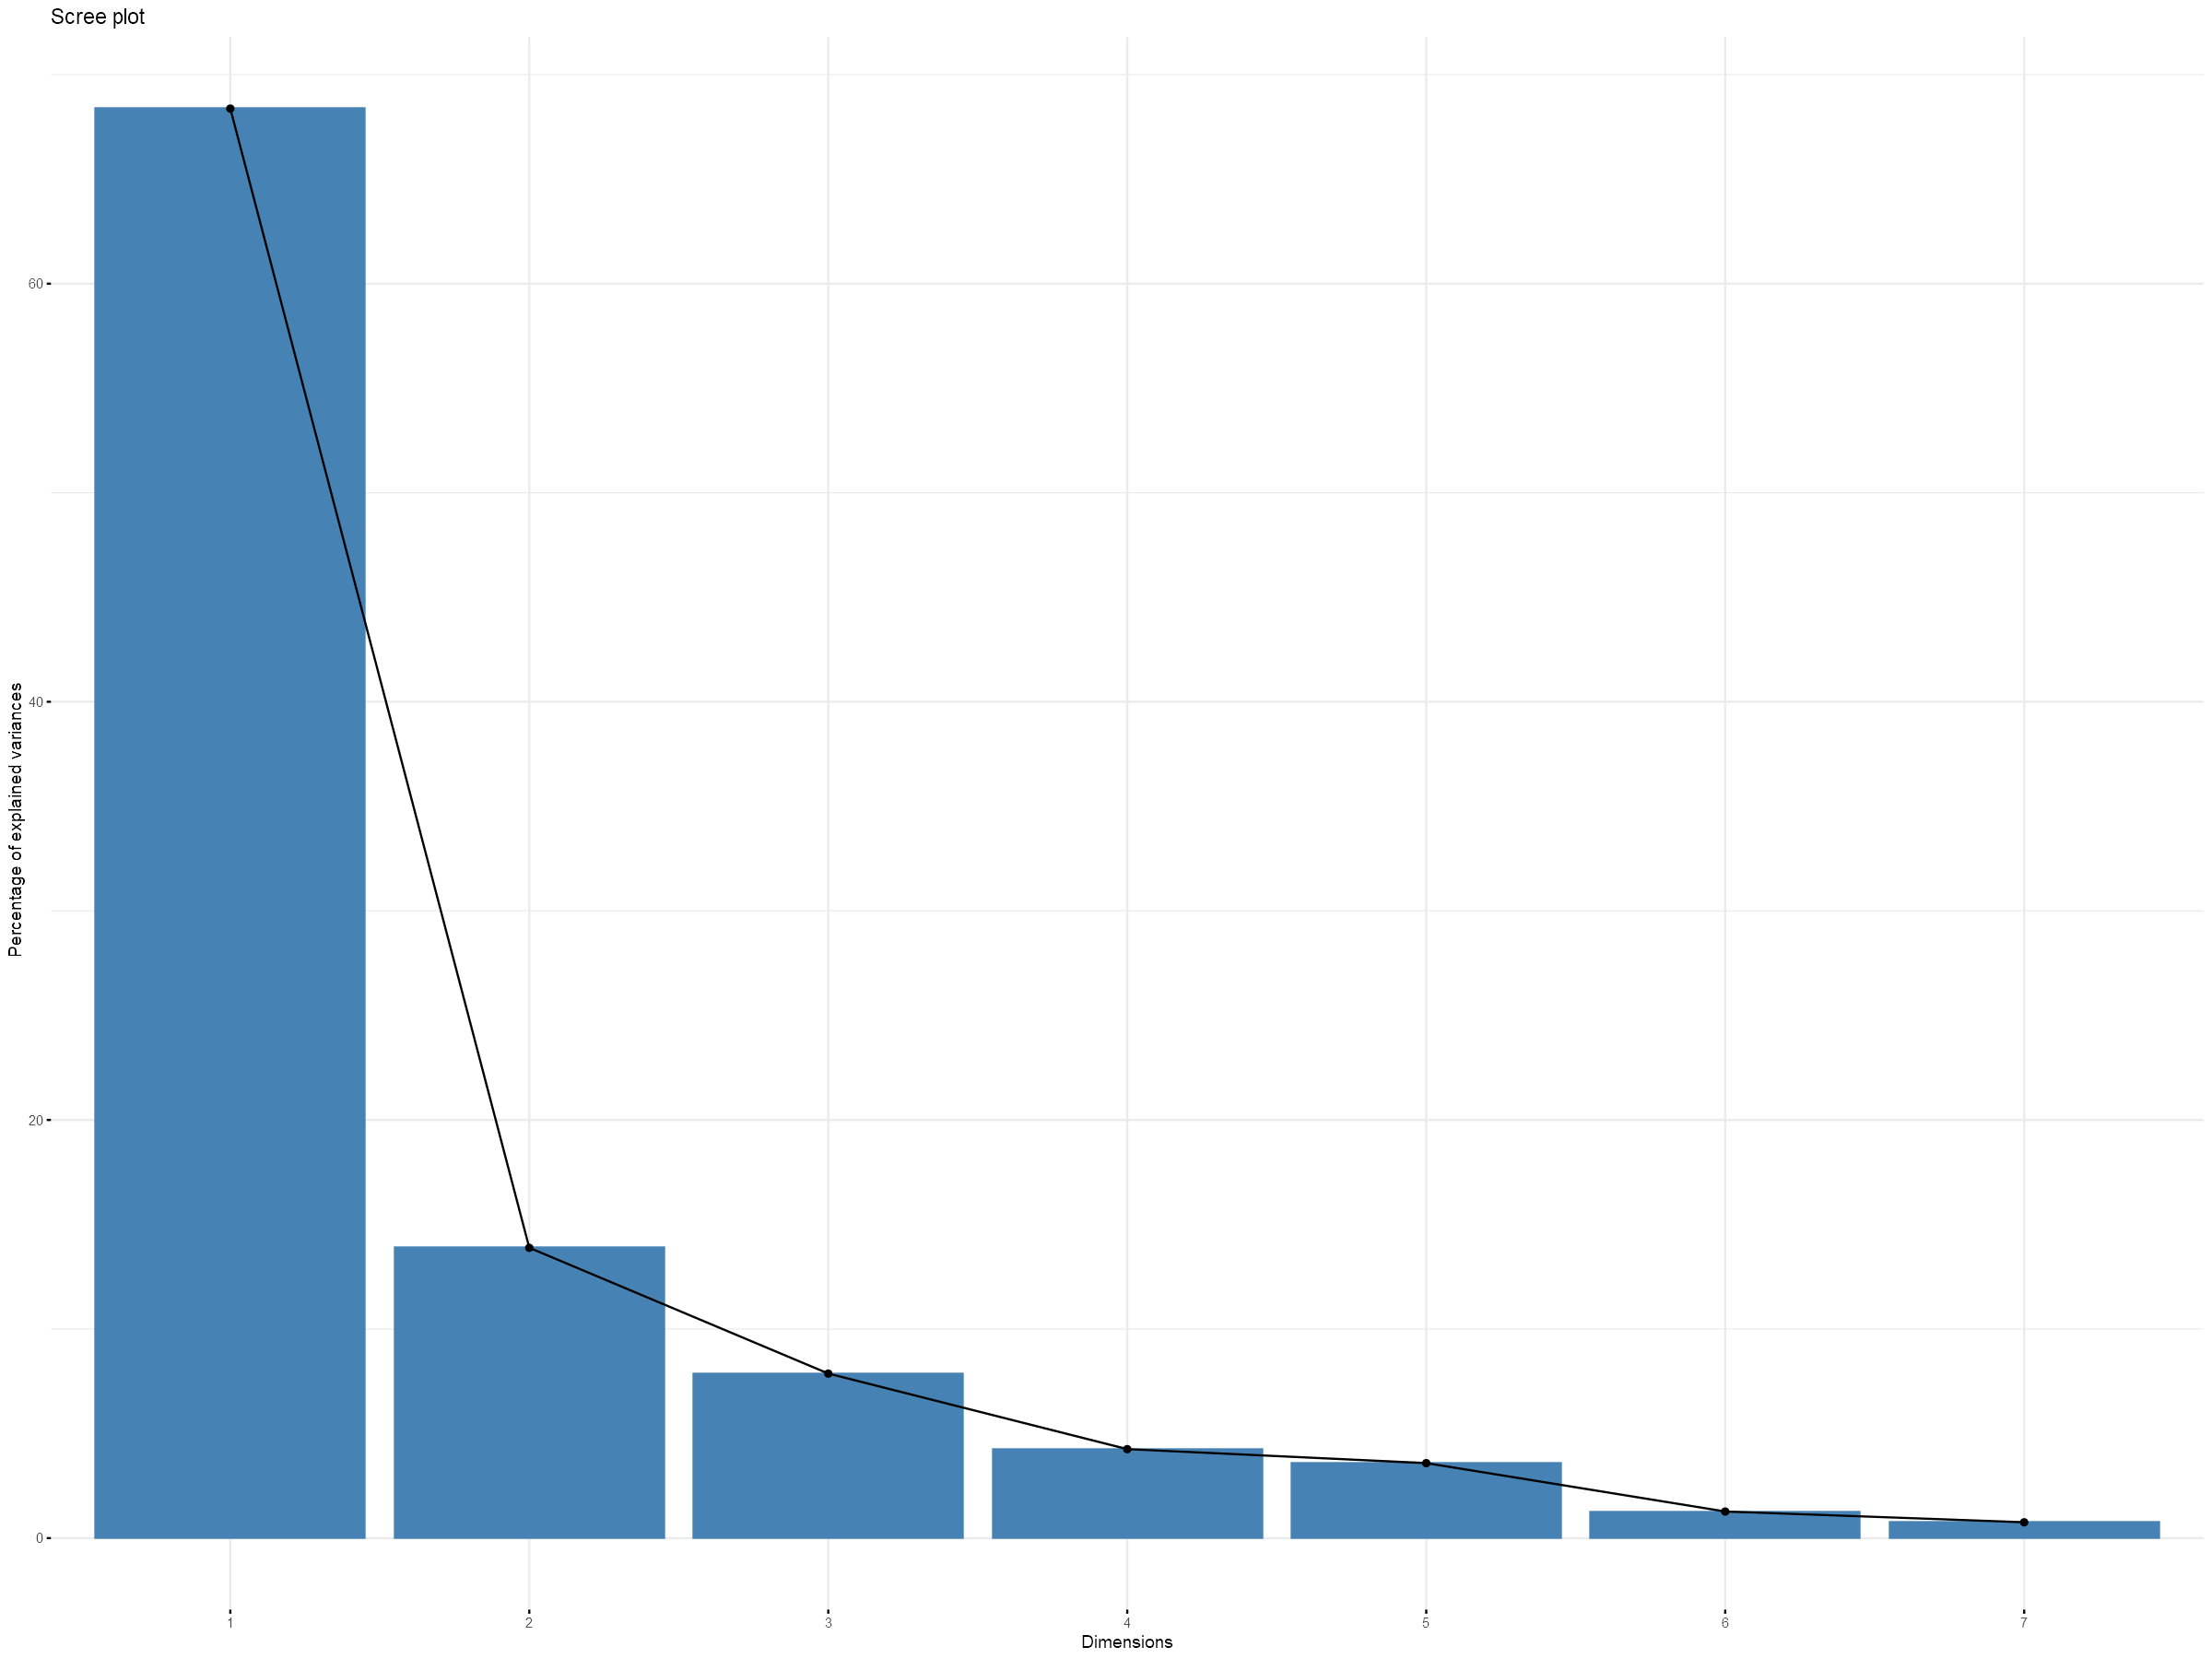

In [15]:
res.pca <- prcomp(df.scaled, scale = FALSE)
fviz_eig(res.pca)

#### 90% вариации данных объясняются первыми тремя главными компонентами

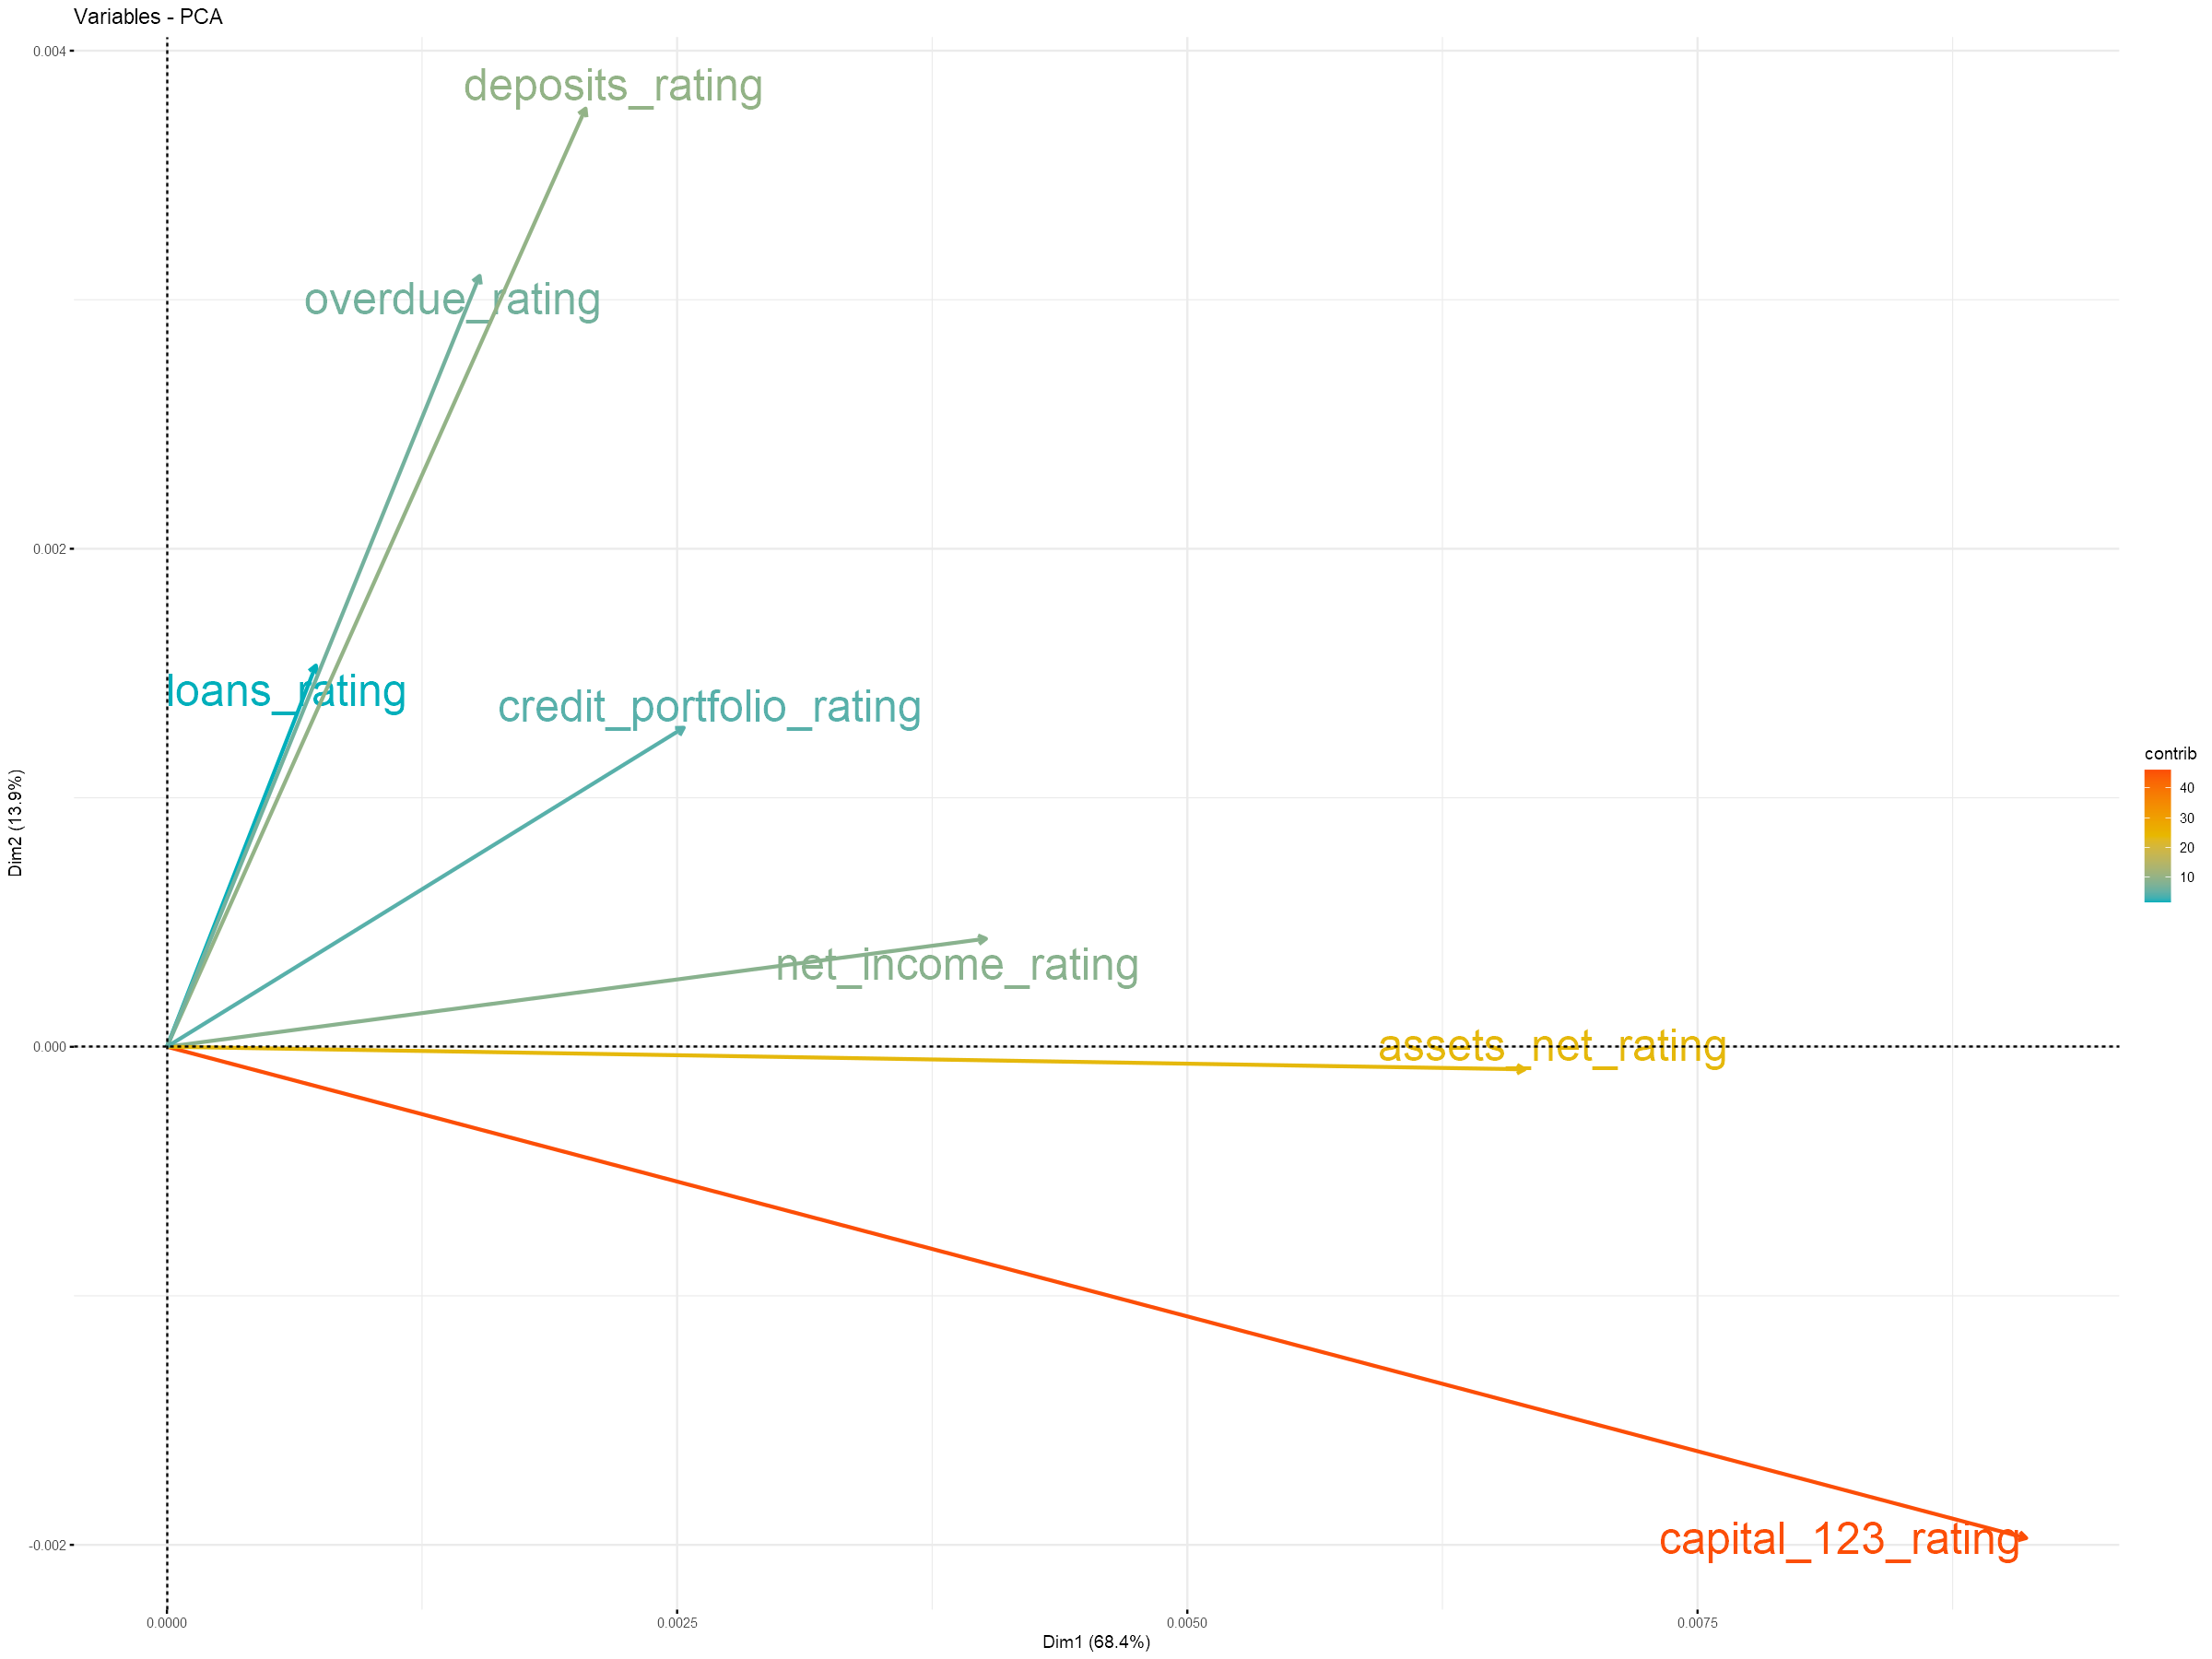

In [16]:
#визуализация первых двух главных компонент на векторном пространстве
fviz_pca_var(res.pca,
             col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,
             arrowsize = 0.9, labelsize = 10, 
             )

#### Наибольший вклад вносит признак Капитал, наименьший - кредиты физ. лицам

In [17]:
#Сохраняем первые три главные компоненты в качестве новых фичей
df.pca <- predict(res.pca, newdata = df.scaled)[,1:3]

#### Посмотрим на корреляцию наблюдений

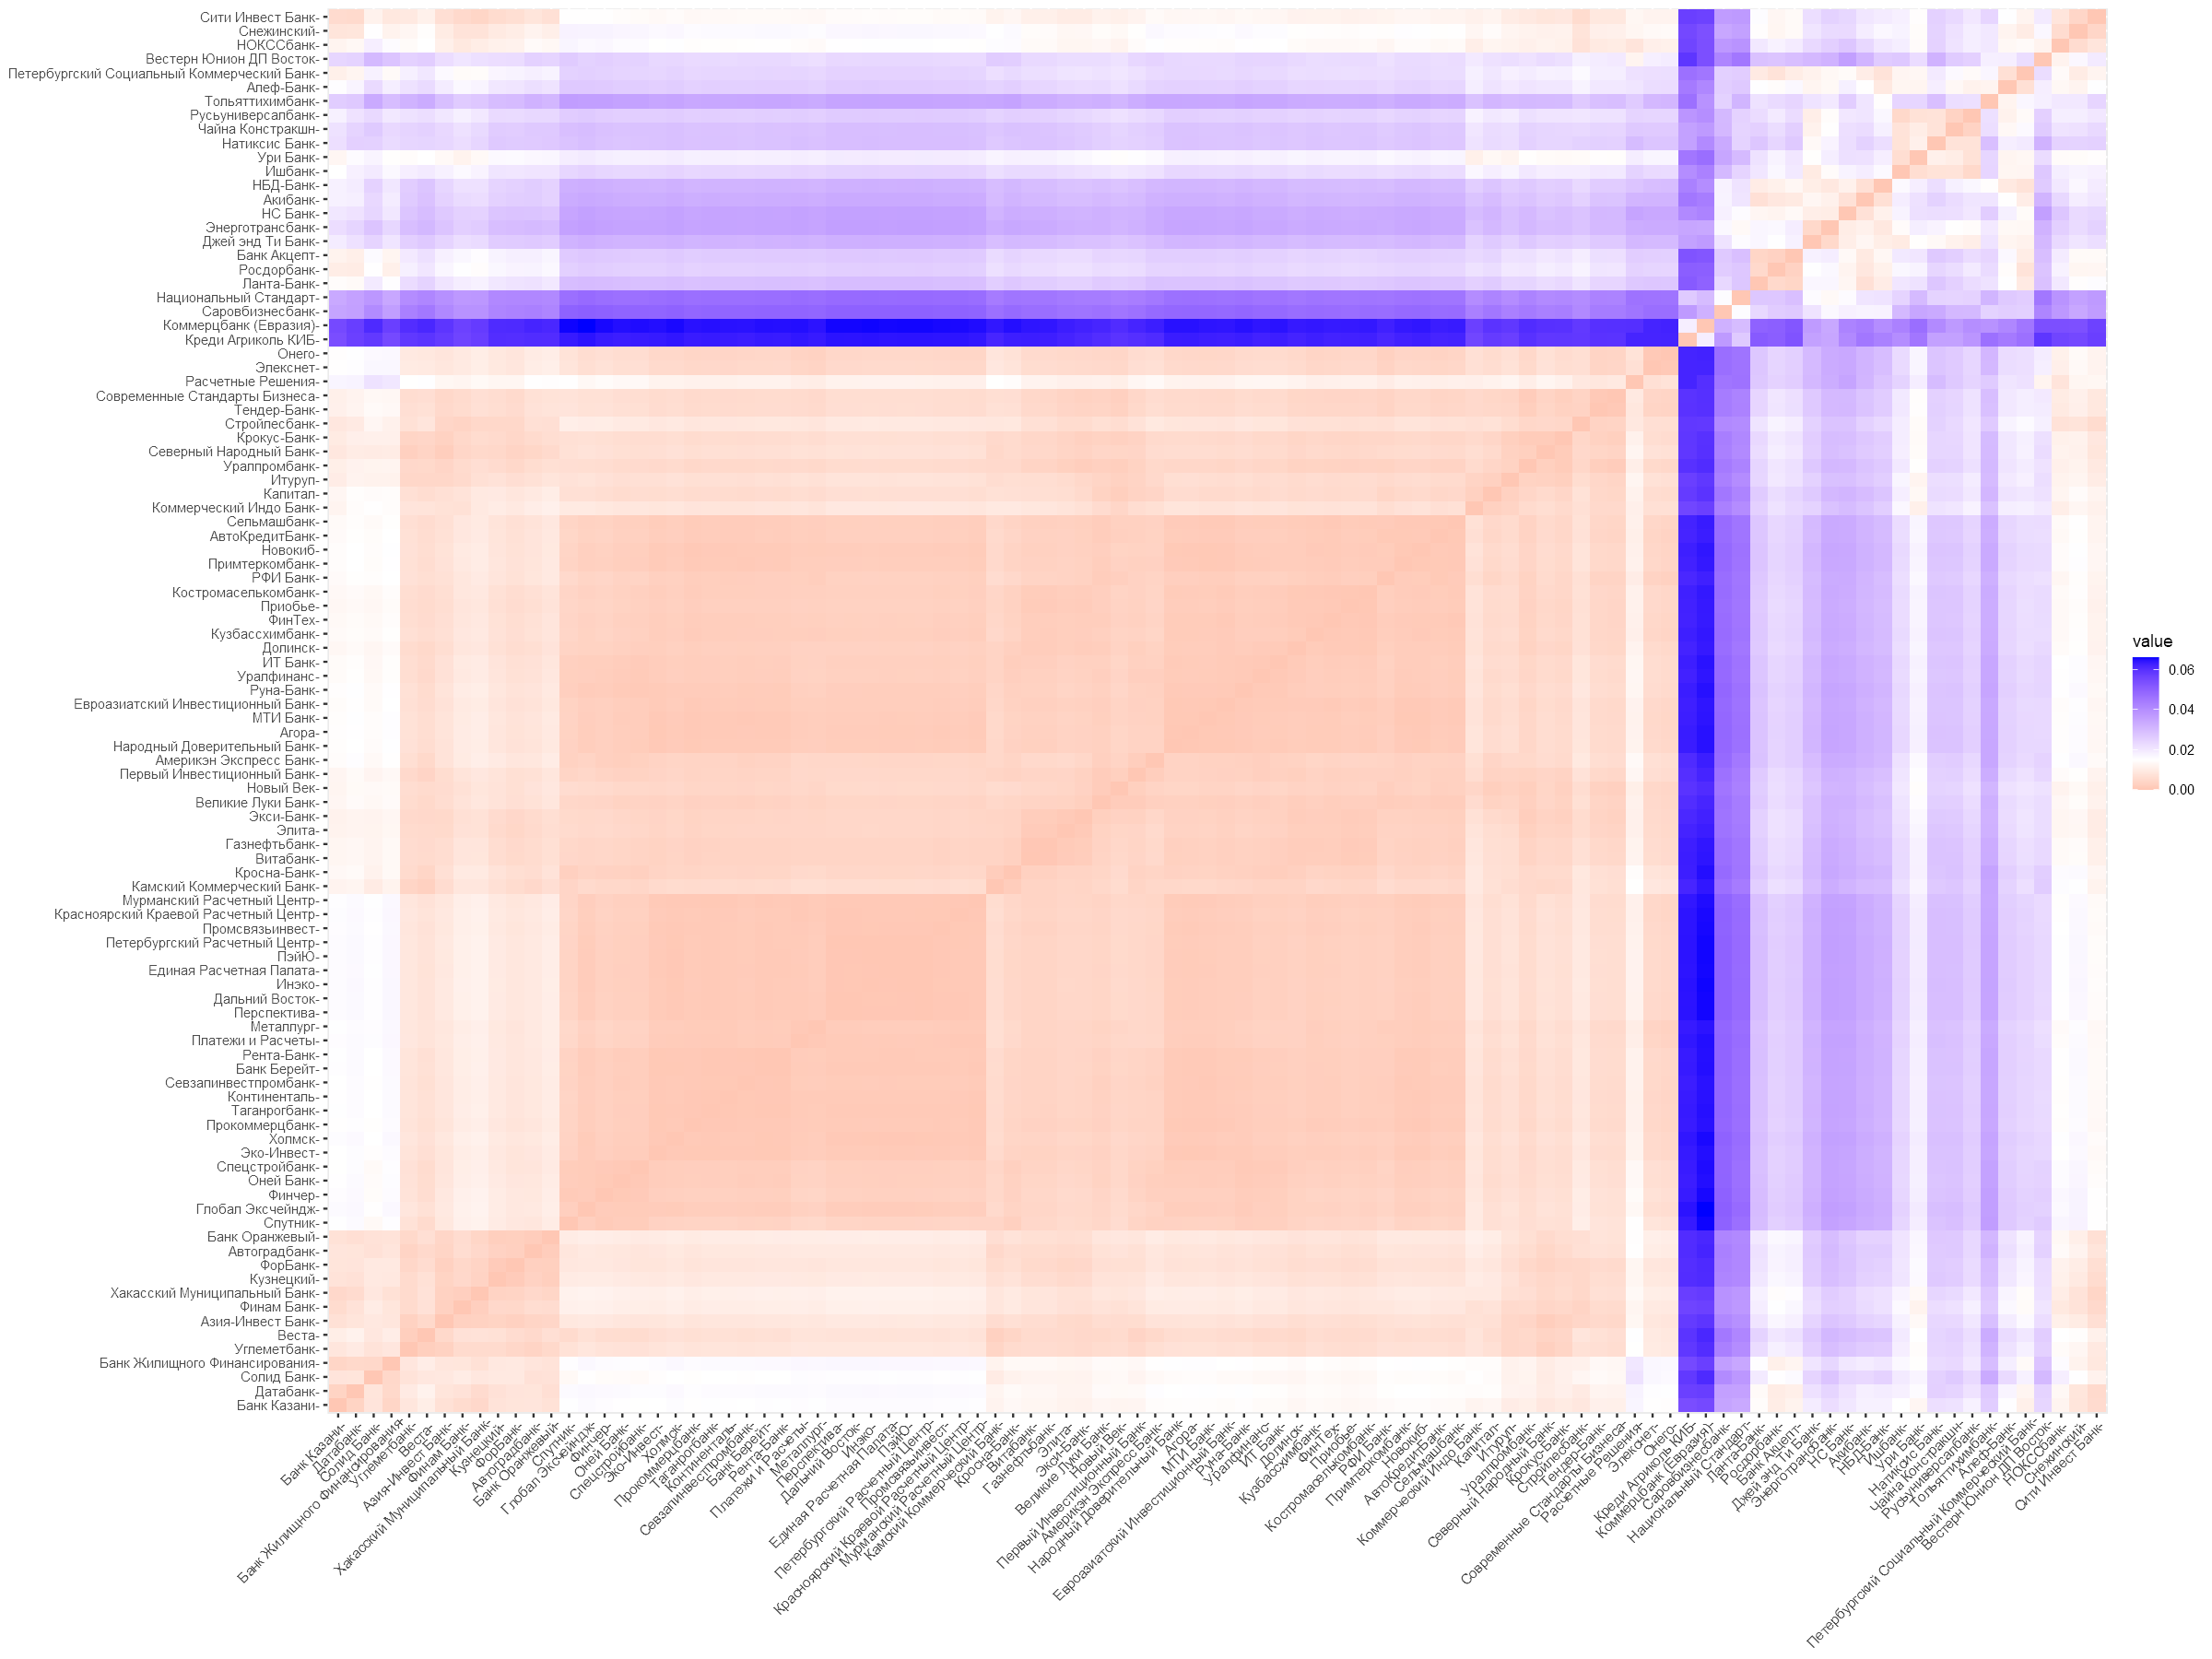

In [18]:
#heatmap евклидовых расстояний между 100 случайными банками
distances <- dist(df.pca[sample(1:nrow(df.pca), 100),], method = 'euclidean')
fviz_dist(distances)

#### Проведем иерархическую кластеризацию исходных данных с применением метода Варда. Визуализируем дендрограмму для 100 случайных банков

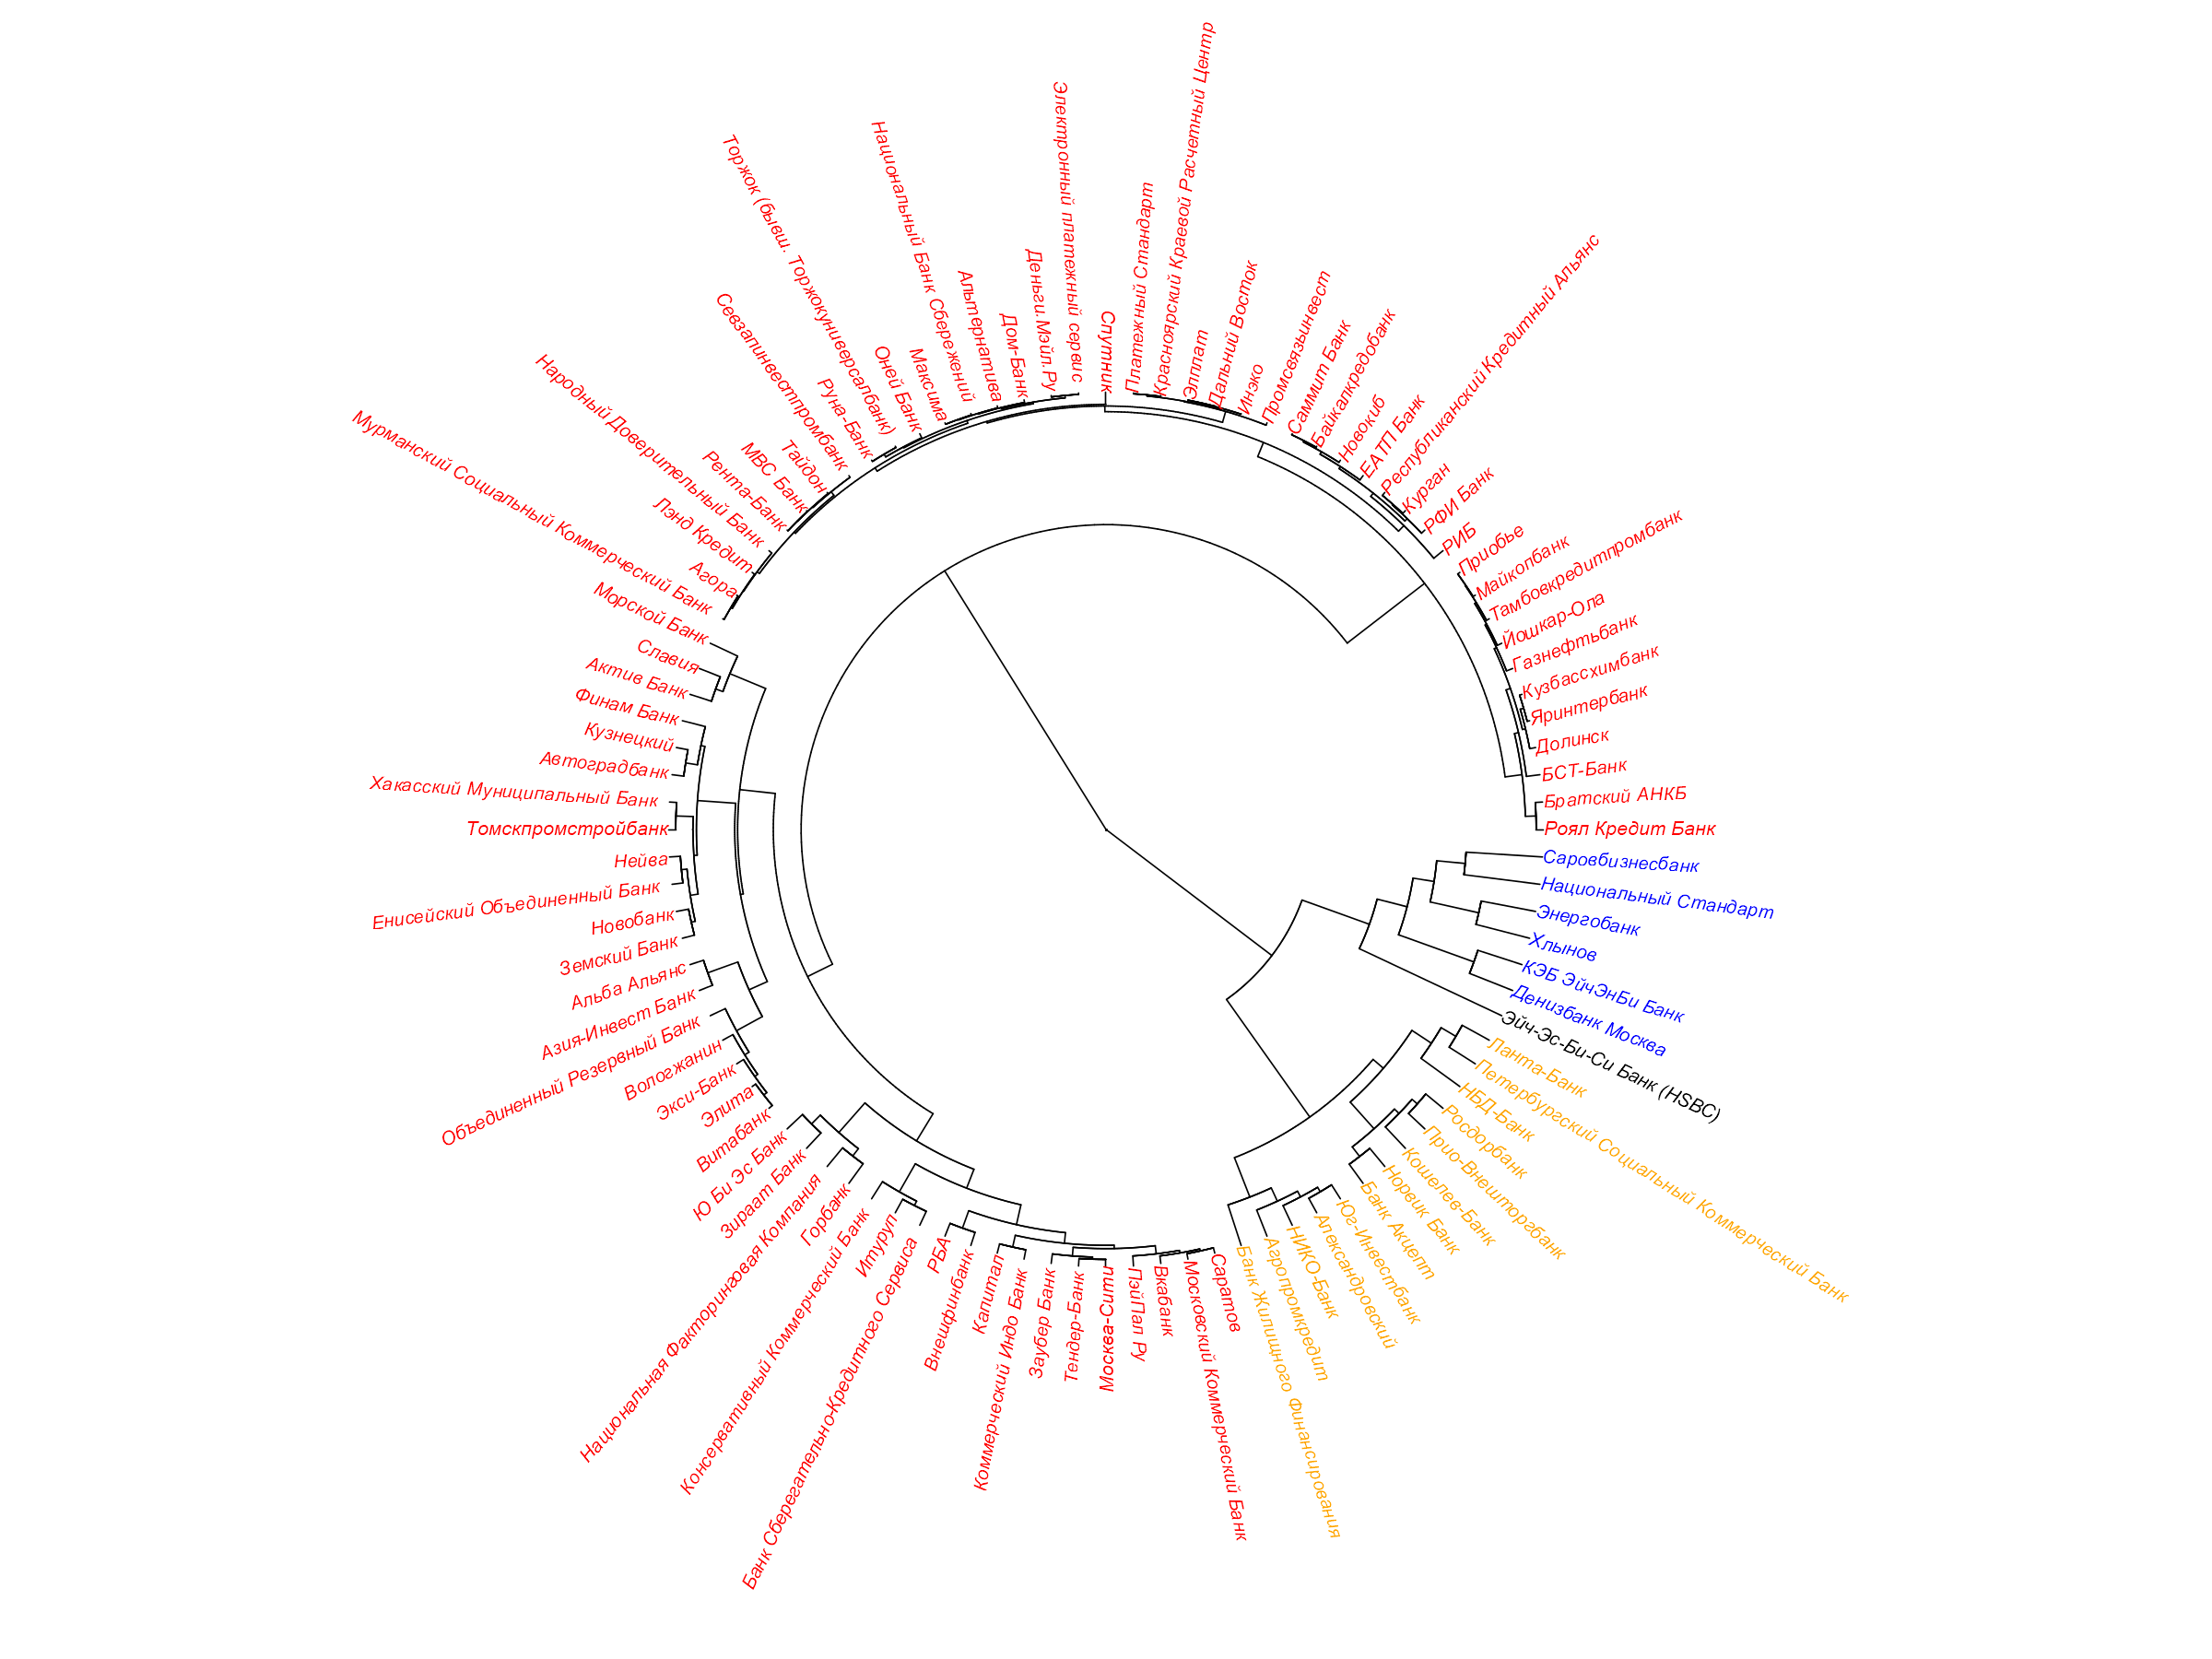

In [19]:
options(op)
options(repr.plot.width=20, repr.plot.height=15)
res.hc <- hclust(dist(df.scaled[sample(1:nrow(df.scaled), 100),]), method = "ward.D2")

#Дендрограмма для 100 банков
colors = c("red", "blue", "orange", "black")
clus4 = cutree(res.hc, 4)
plot(as.phylo(res.hc), type = "fan", tip.color = colors[clus4], cex = 1, no.margin = T)

#### Видно, что зарубежные банки объединились в отдельный кластер. Кроме того, выделилась обширная группа региональных банков.

#### Подберем оптимальное число кластеров с применением метода k-средних.

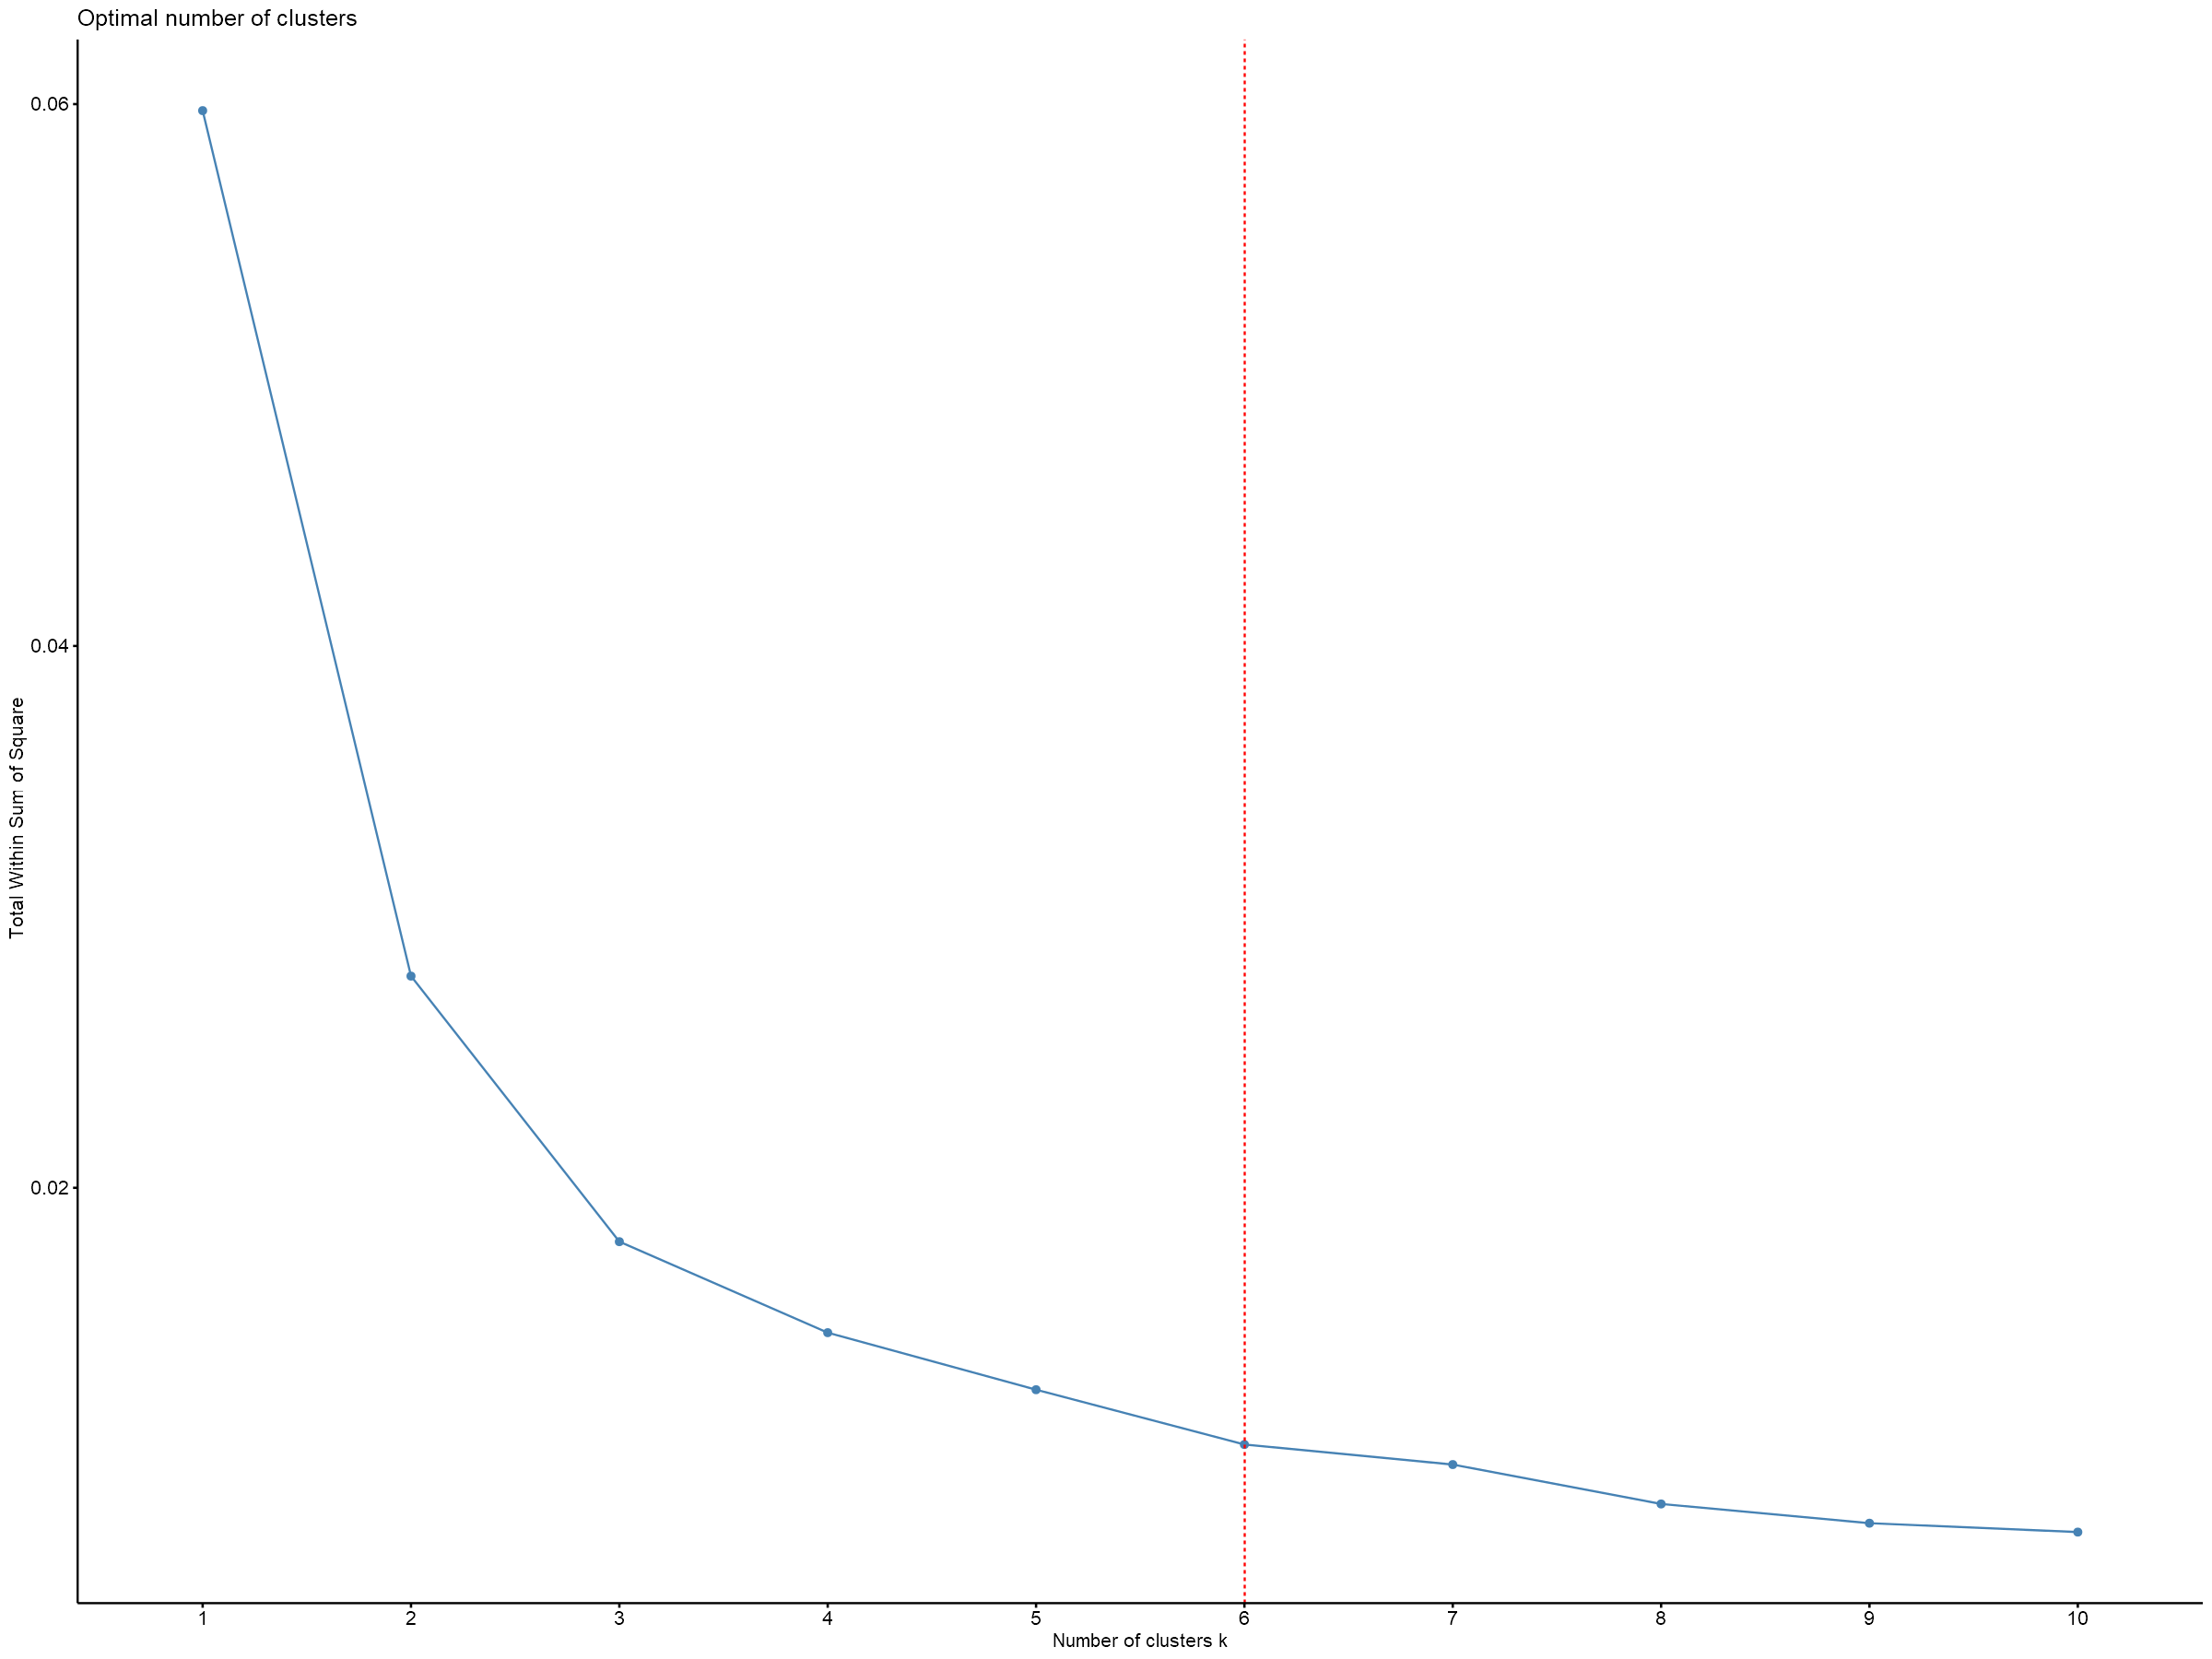

In [20]:
options(op)

fviz_nbclust(df.pca, kmeans, method = 'wss')+
  geom_vline(xintercept=6, color = 'red', linetype=2)

#### Общая сумма квадратов расстояний внутри кластеров достигает достаточно низкого значения уже на 6 кластере. Остановимся на этом числе групп банков для последующего анализа.

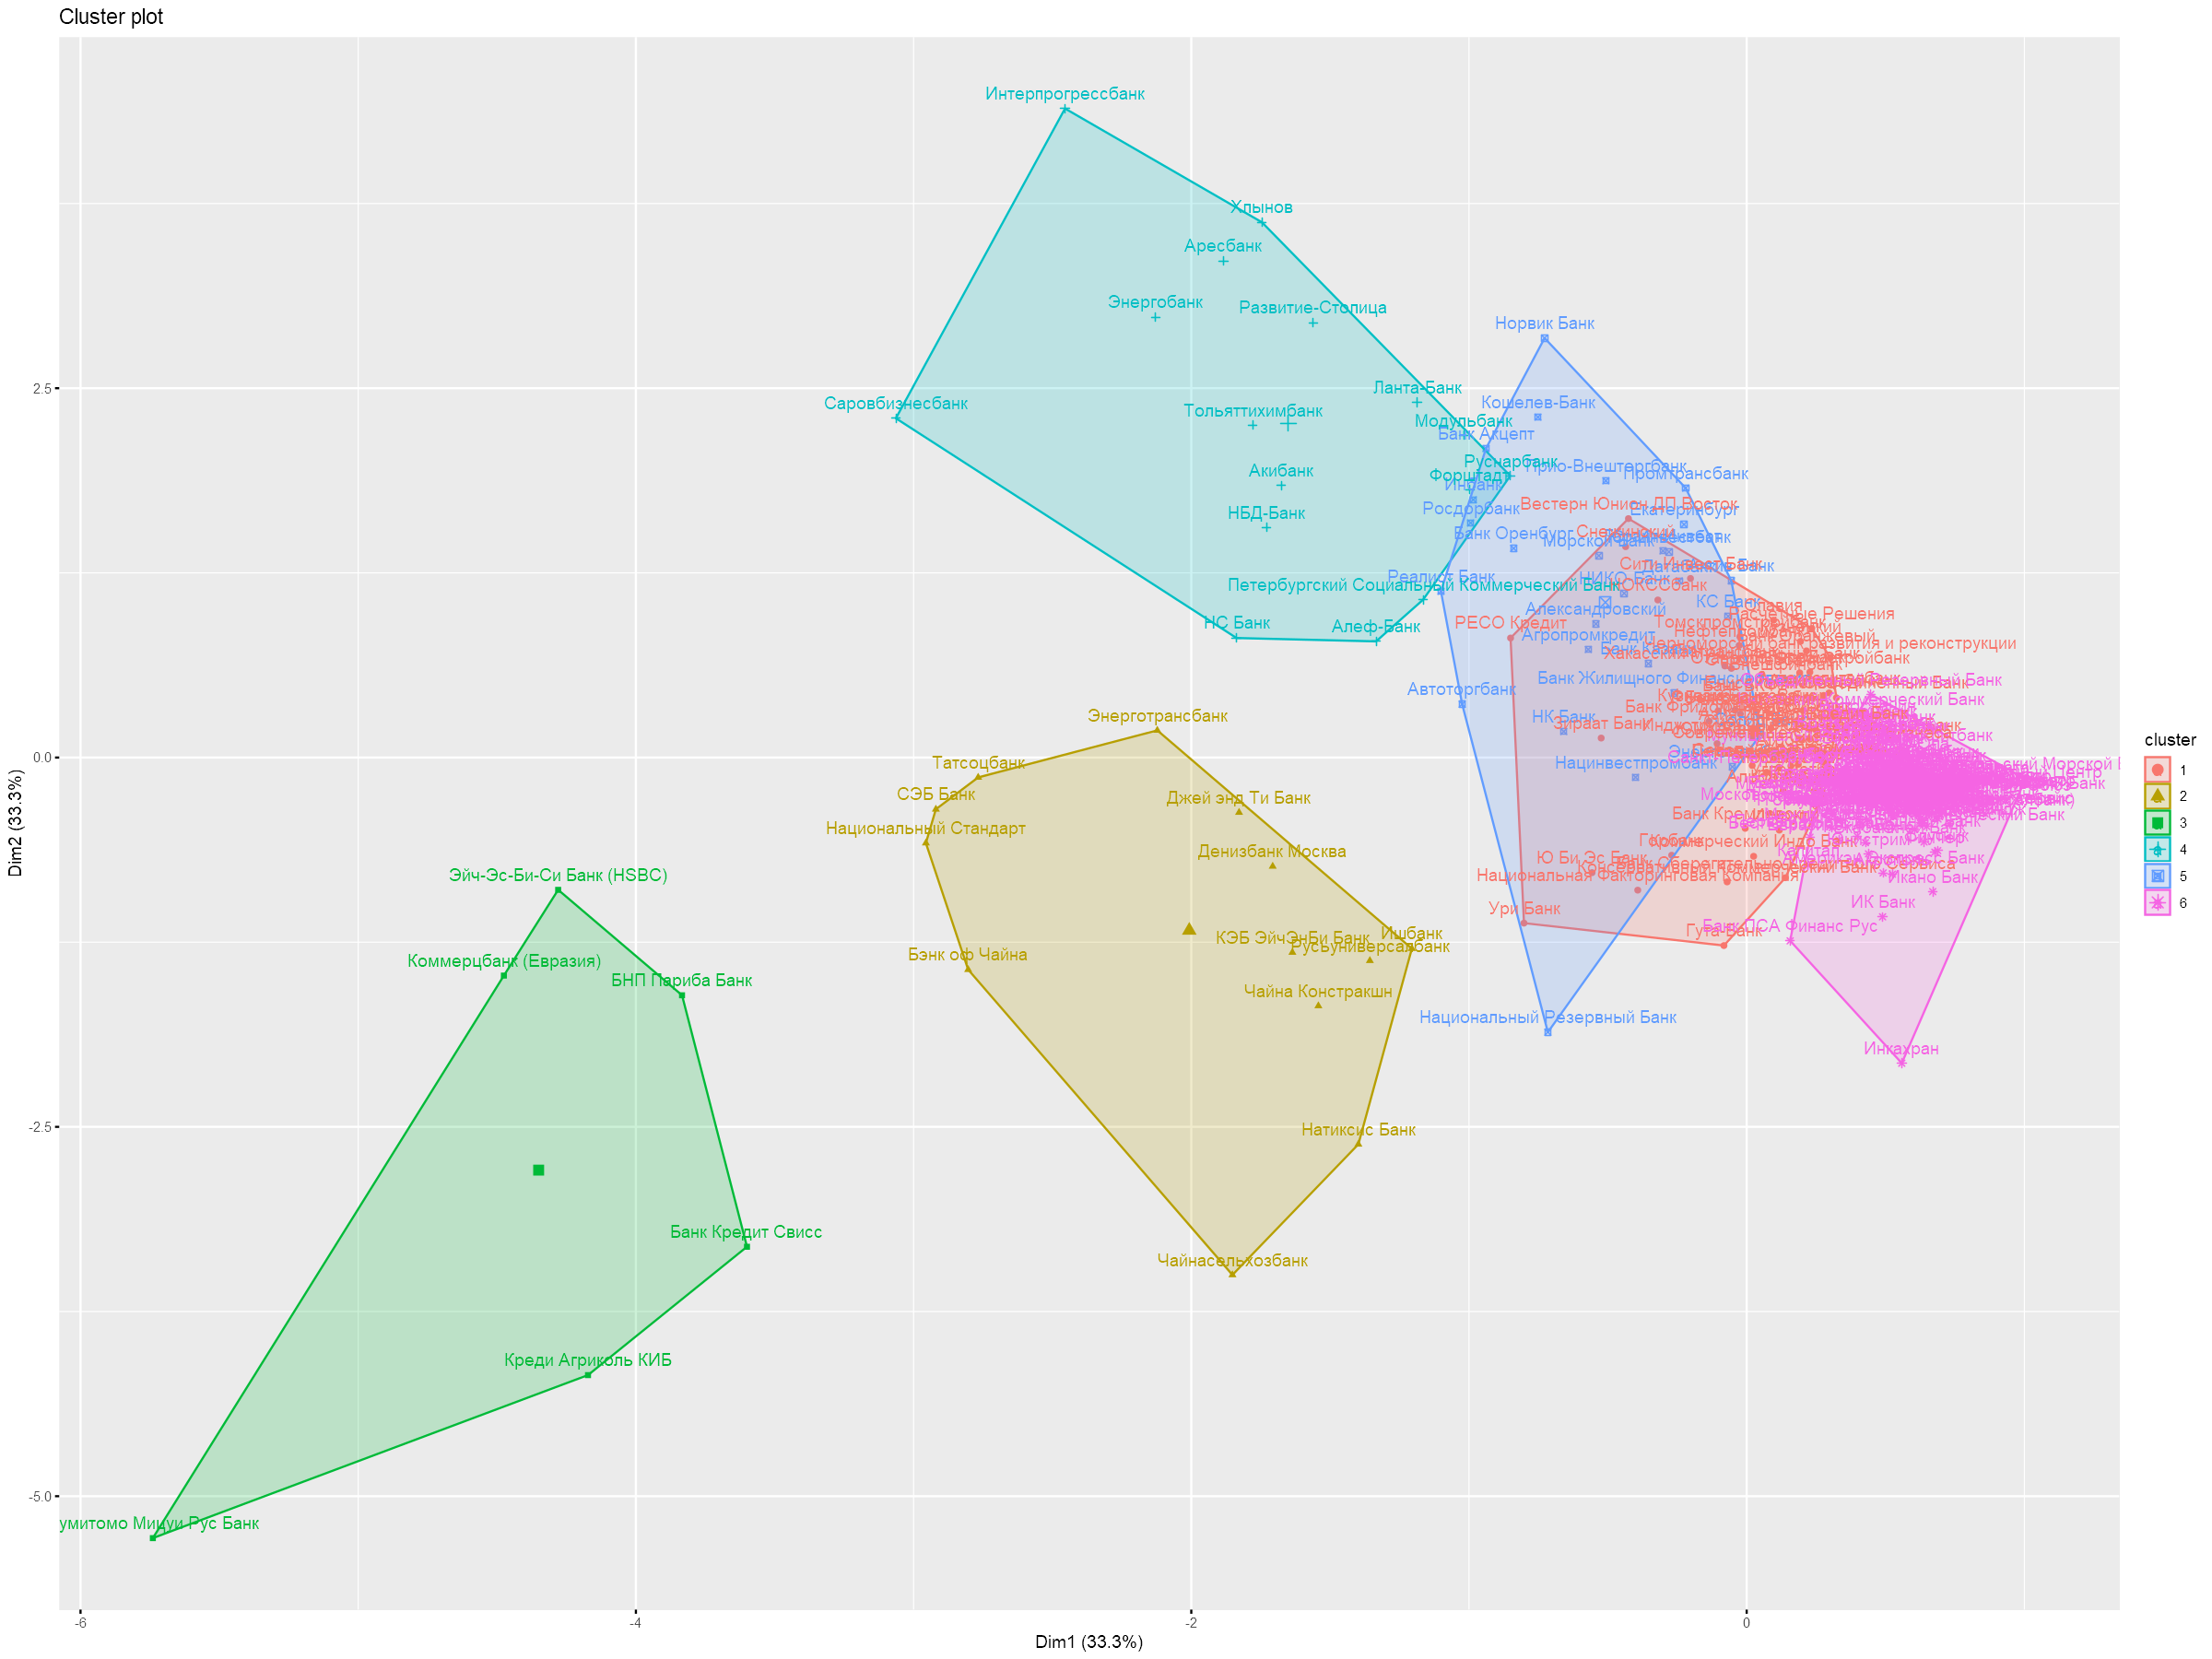

In [21]:
options(repr.plot.width=20, repr.plot.height=15)
set.seed(2020)
cl <- kmeans(df.pca, 6, nstart = 25)
km.res <- kmeans(df.pca, 6)
fviz_cluster(km.res, df.pca)

#### Кластеры 4,5 и 6 накладываются друг на друга в двумерной проекции. Посмотрим расположение кластеров в трехмерном пространстве в зависимости от значений первых трех главных компонент.

In [22]:
options(op)
res.km <- kmeans(df.pca,6)$cluster

df.pca1 <- df.pca
df.pca1 <- cbind(df.pca1, cluster = res.km)

In [23]:
#Создадим трехменое отображение кластеров банков
colors <- viridis(n=6)

scatter3d(x = data.frame(df.pca1)[,1], 
          y = data.frame(df.pca1)[,2],
          z = data.frame(df.pca1)[,3],
          surface.col = colors,
          groups = as.factor(data.frame(df.pca1)$cluster),
          surface=F,
          grid = F,
          ellipsoid = T
          )

rglwidget()
#график можно крутить и увеличивать :)

Loading required namespace: mgcv

Loading required namespace: rmarkdown



HTML widgets cannot be represented in plain text (need html)

In [24]:
#красивый plot_ly не отображается в pdf :(

# p <- plot_ly(data.frame(df.pca1), x=~PC1, y=~PC2, 
#              mode = 'text', 
#              text = row.names(df.pca1),
#              z=~PC3, color=~cluster) %>% add_markers(size=2.5)

#### Проведем автоматическую кластеризацию банков с применением карты Кохонена
(красивой визуализации ради)

In [25]:
options(repr.plot.width=20, repr.plot.height=15)
#data_train <- df.scaled
data_train <- df[,4:10]
for (i in 1:ncol(data_train)){
    data_train <- remove_outliers(data_train,i)
}
data_train <- na.omit(data_train)
data_train_matrix <- as.matrix(data_train)
#создаем сетку (grid)
set.seed(2020)
som_grid <- somgrid(xdim = 8, ydim=5, topo="hexagonal")
#фитим модель
som_model <- som(data_train_matrix, 
    grid=som_grid, 
    rlen=2500, 
    alpha=c(0.05,0.01), 
    keep.data = TRUE)

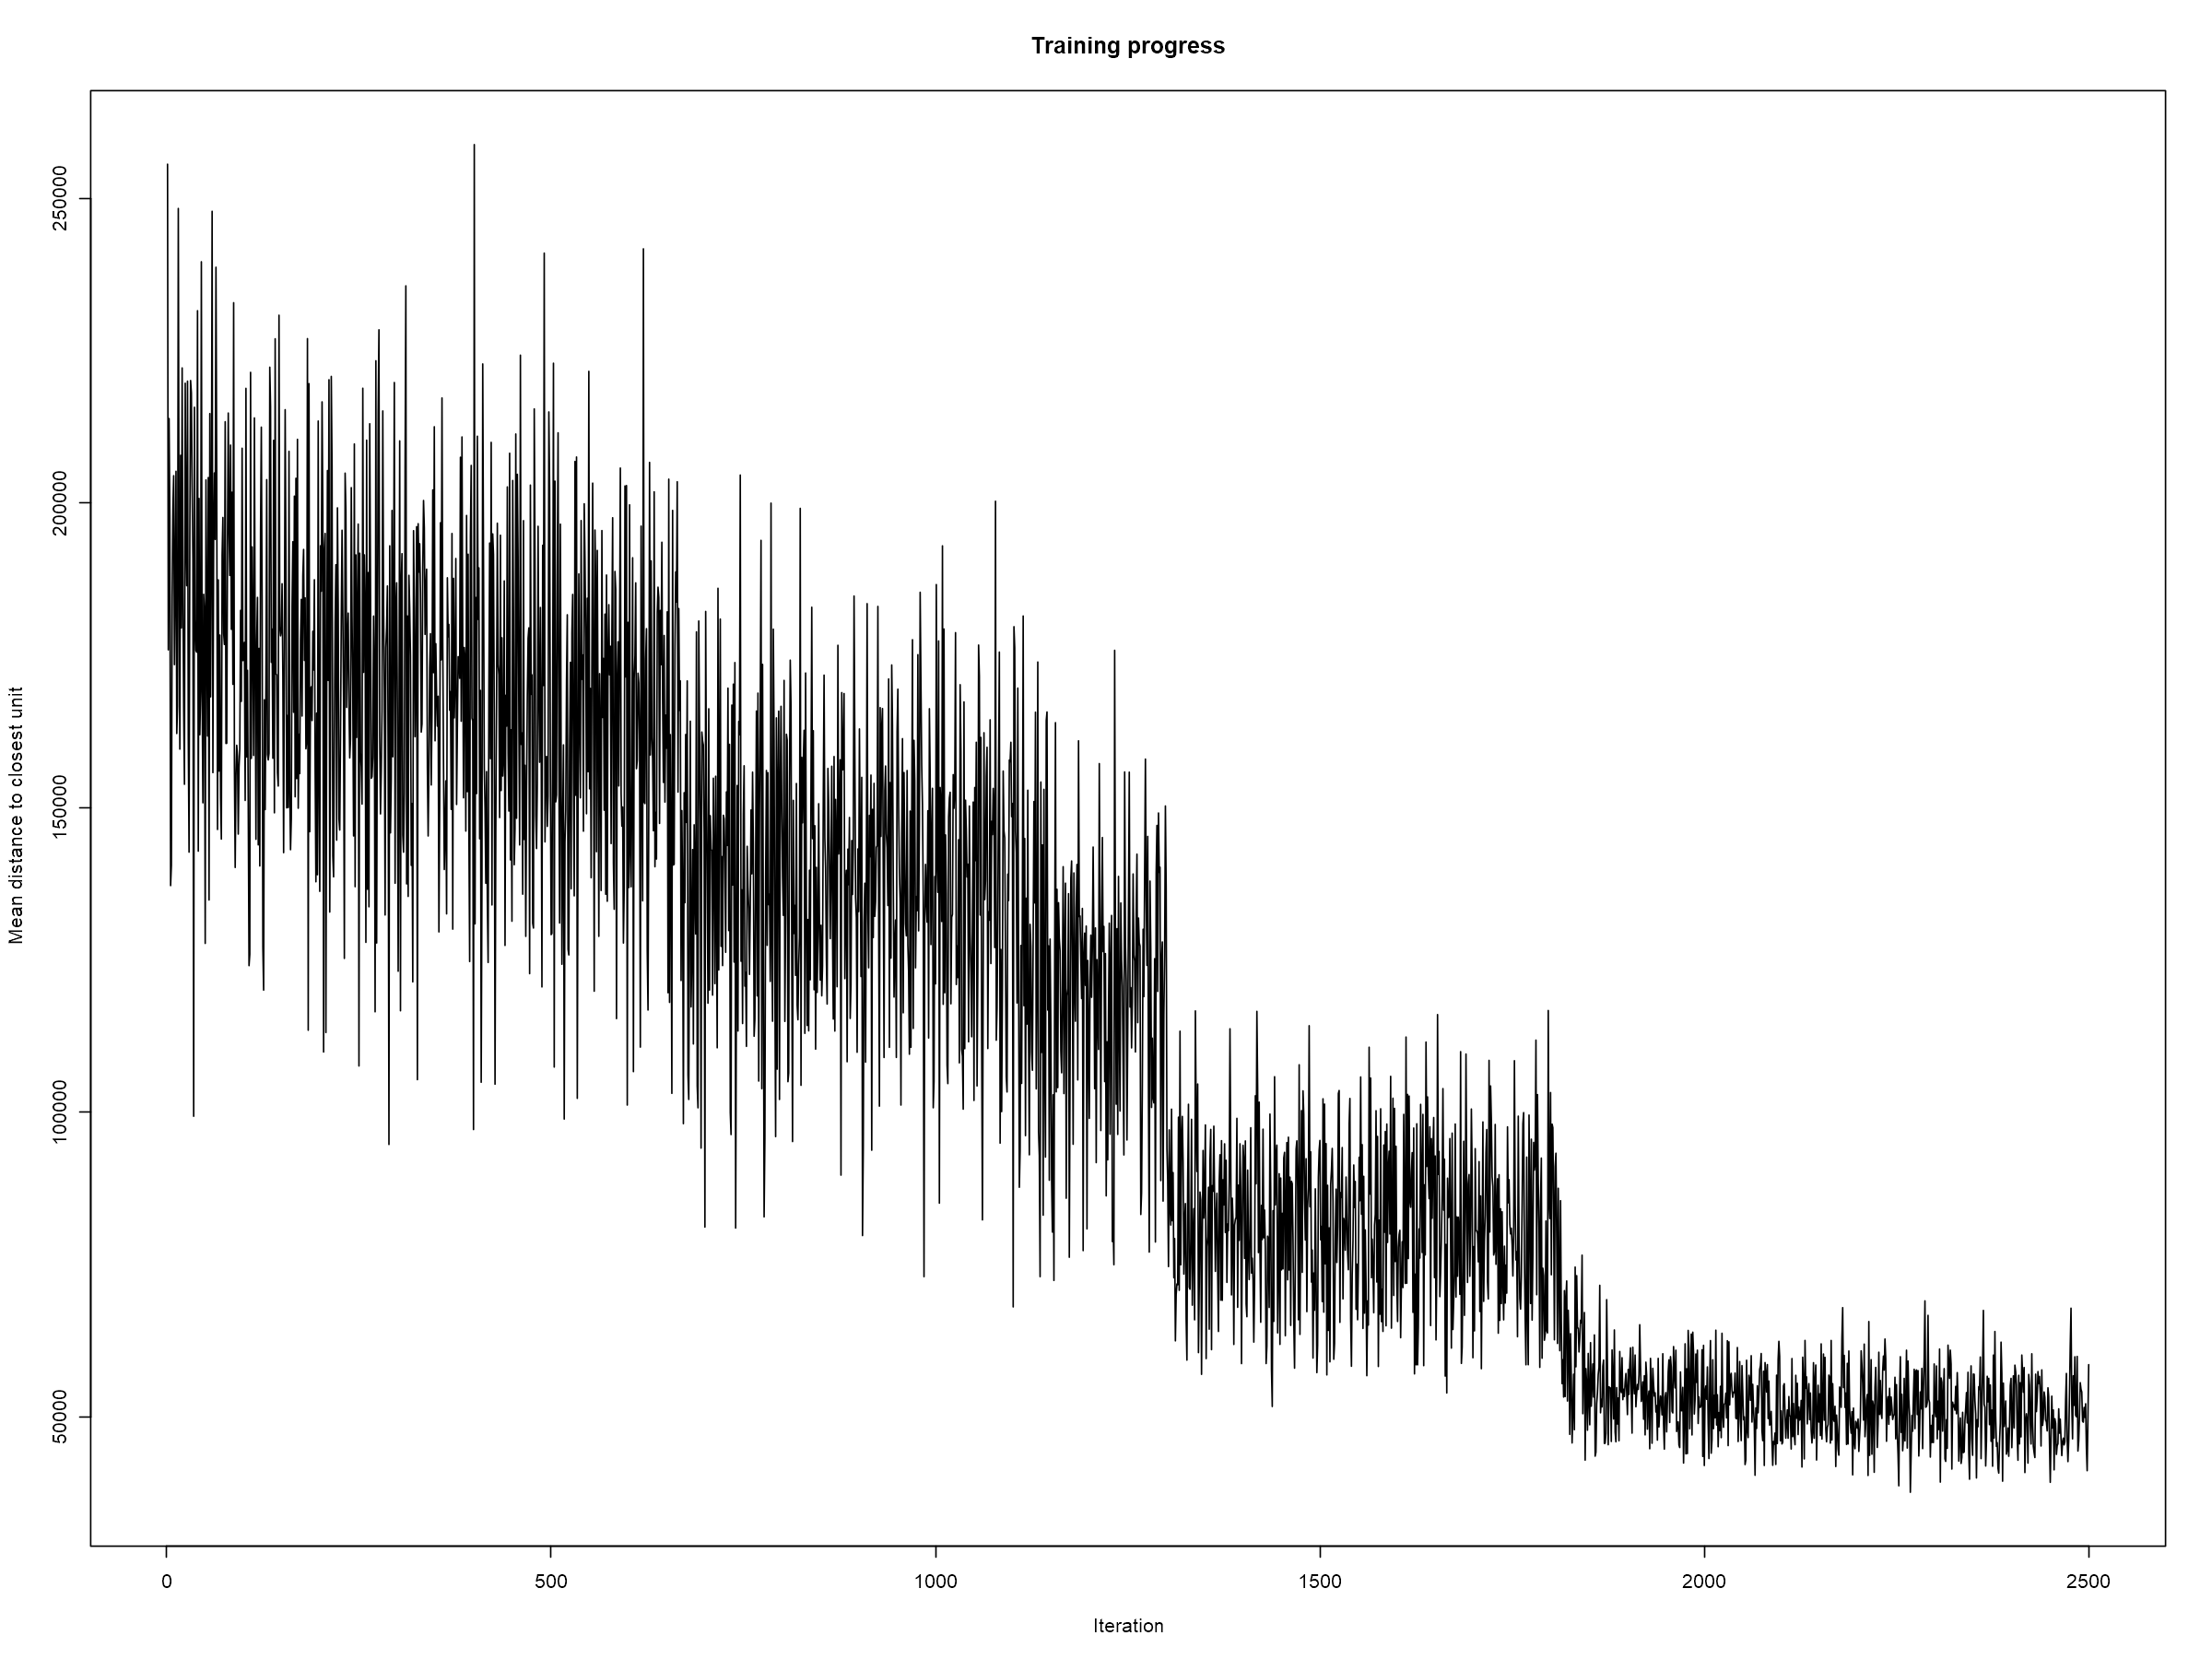

In [26]:
#Процесс обучения SOM
plot(som_model, type="changes")

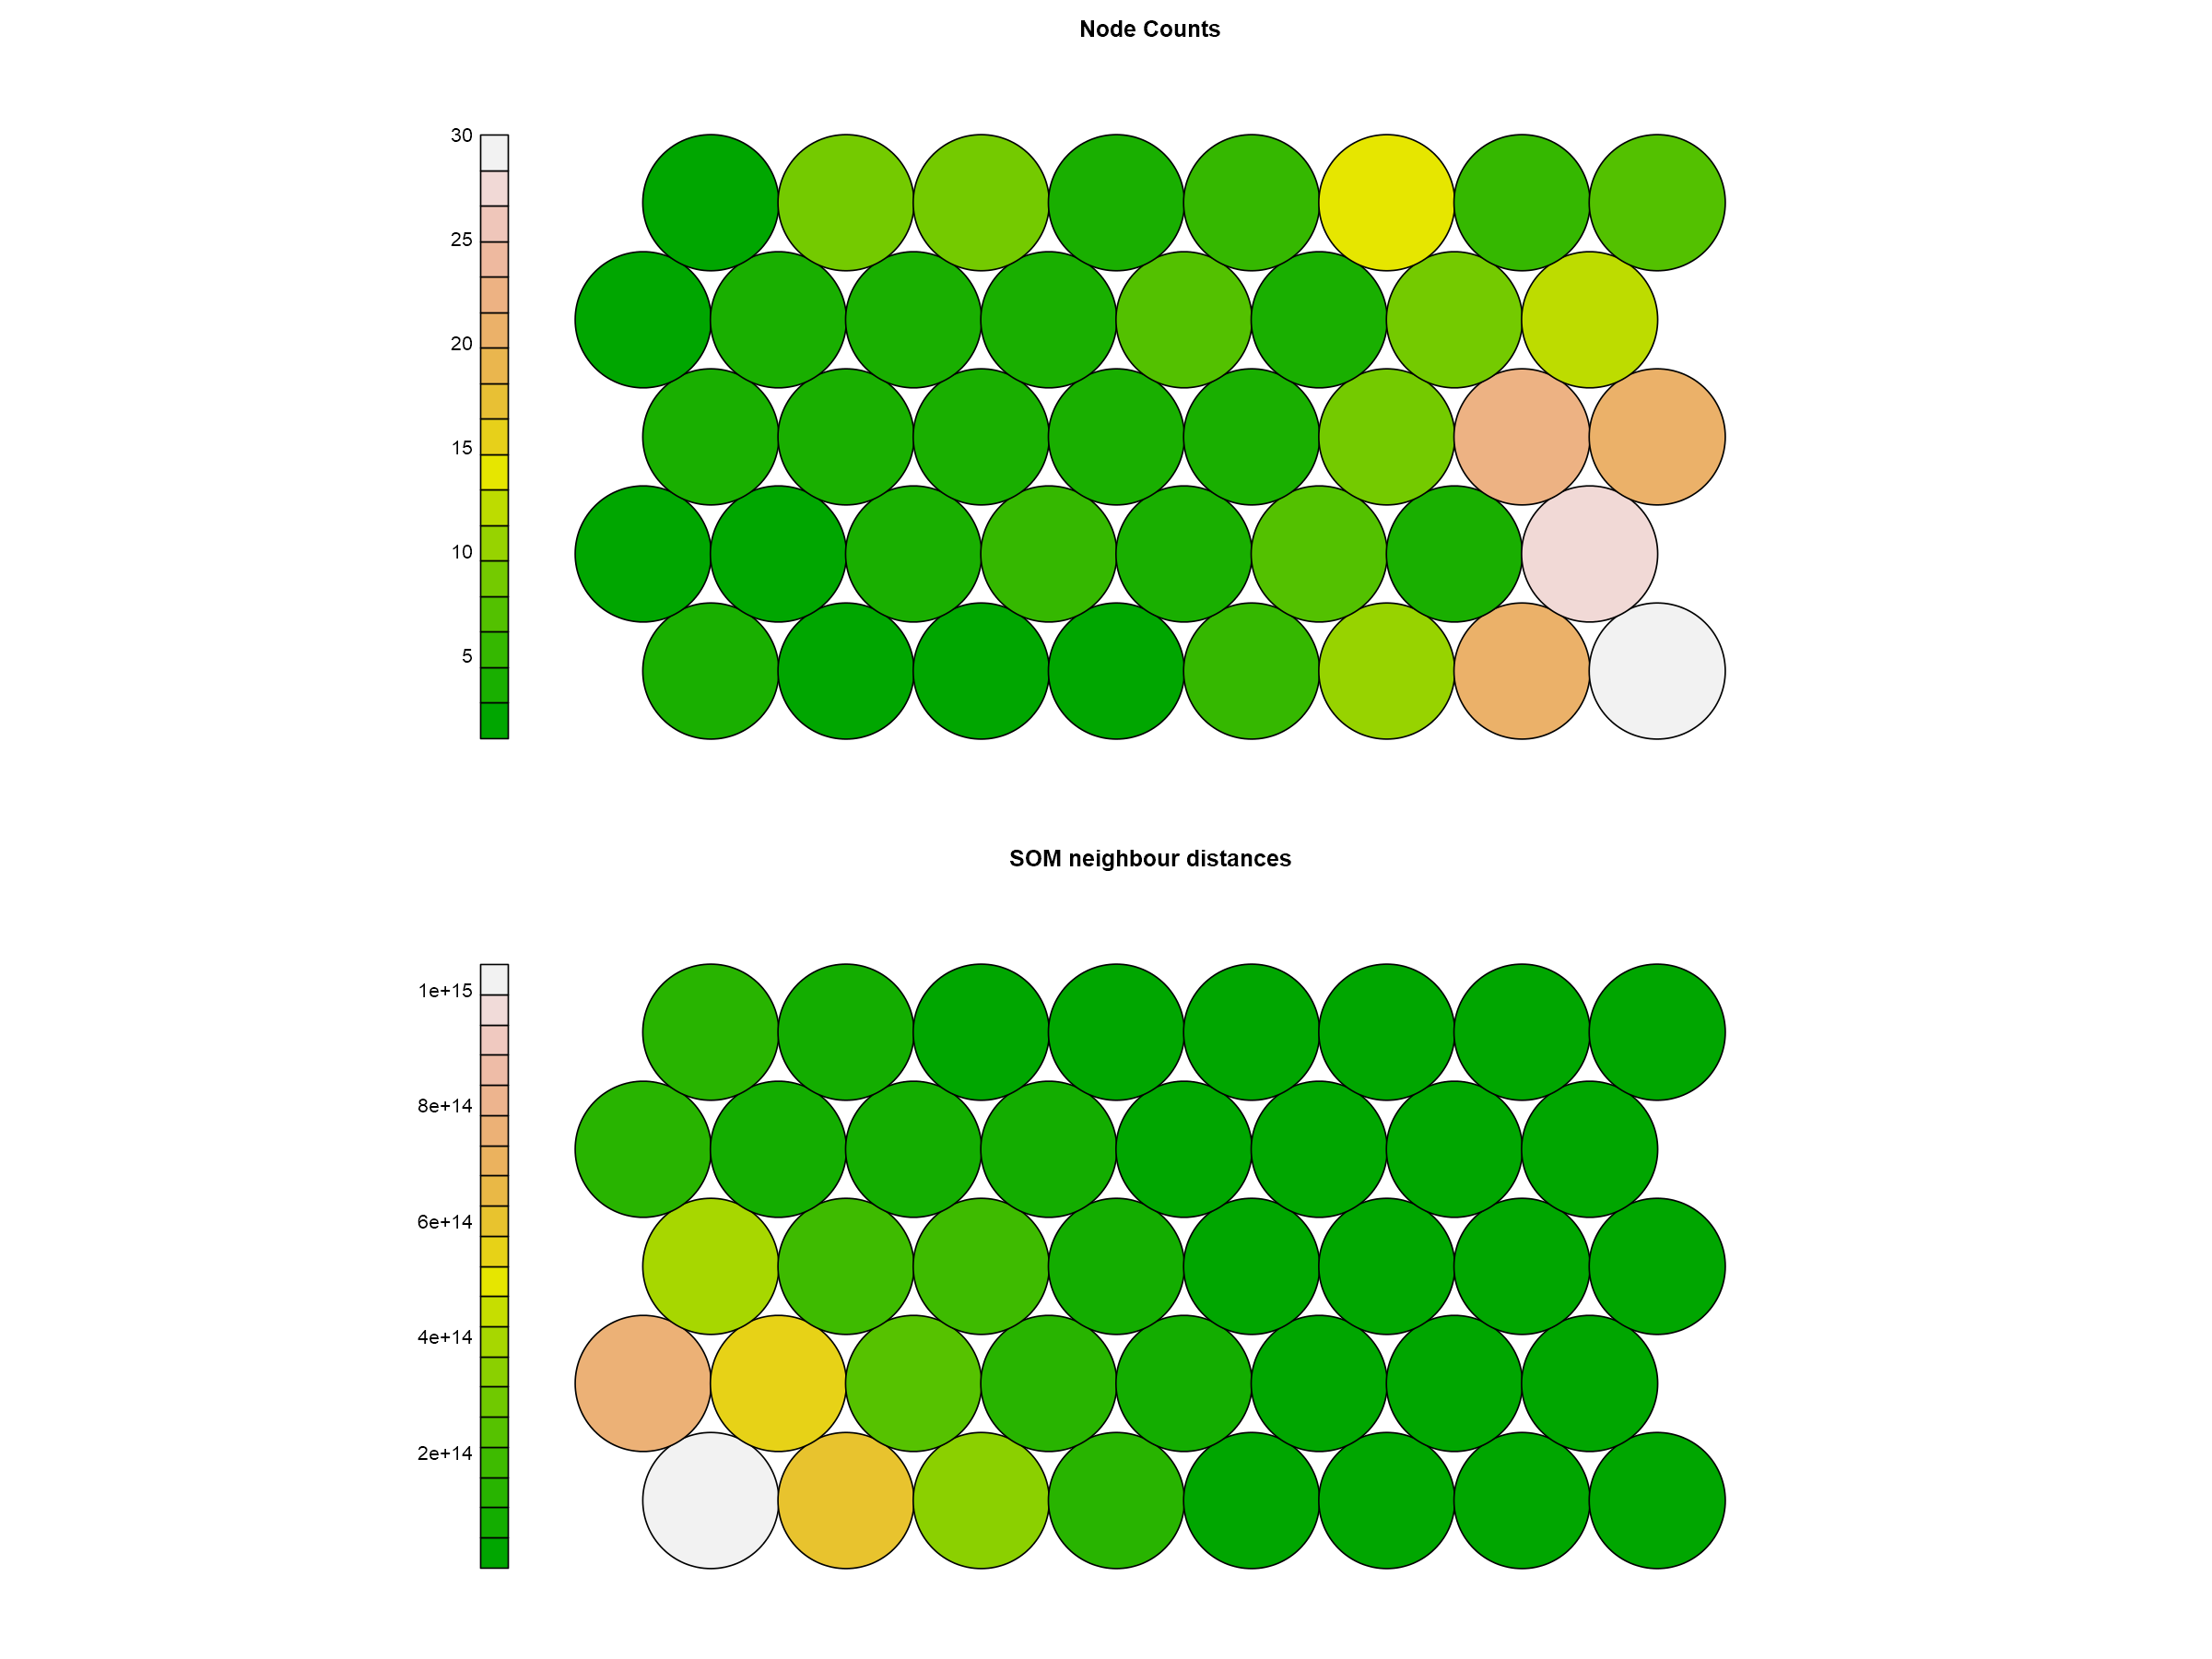

In [27]:
par(mfrow = c(2, 1))
#Node count plot
plot(som_model, type="count", main="Node Counts", palette.name = terrain.colors)
#U-matrix visualisation - "топологическая аналогия" карты - расстояние до ближайшего соседа
plot(som_model, type="dist.neighbours", main = "SOM neighbour distances", palette.name = terrain.colors)

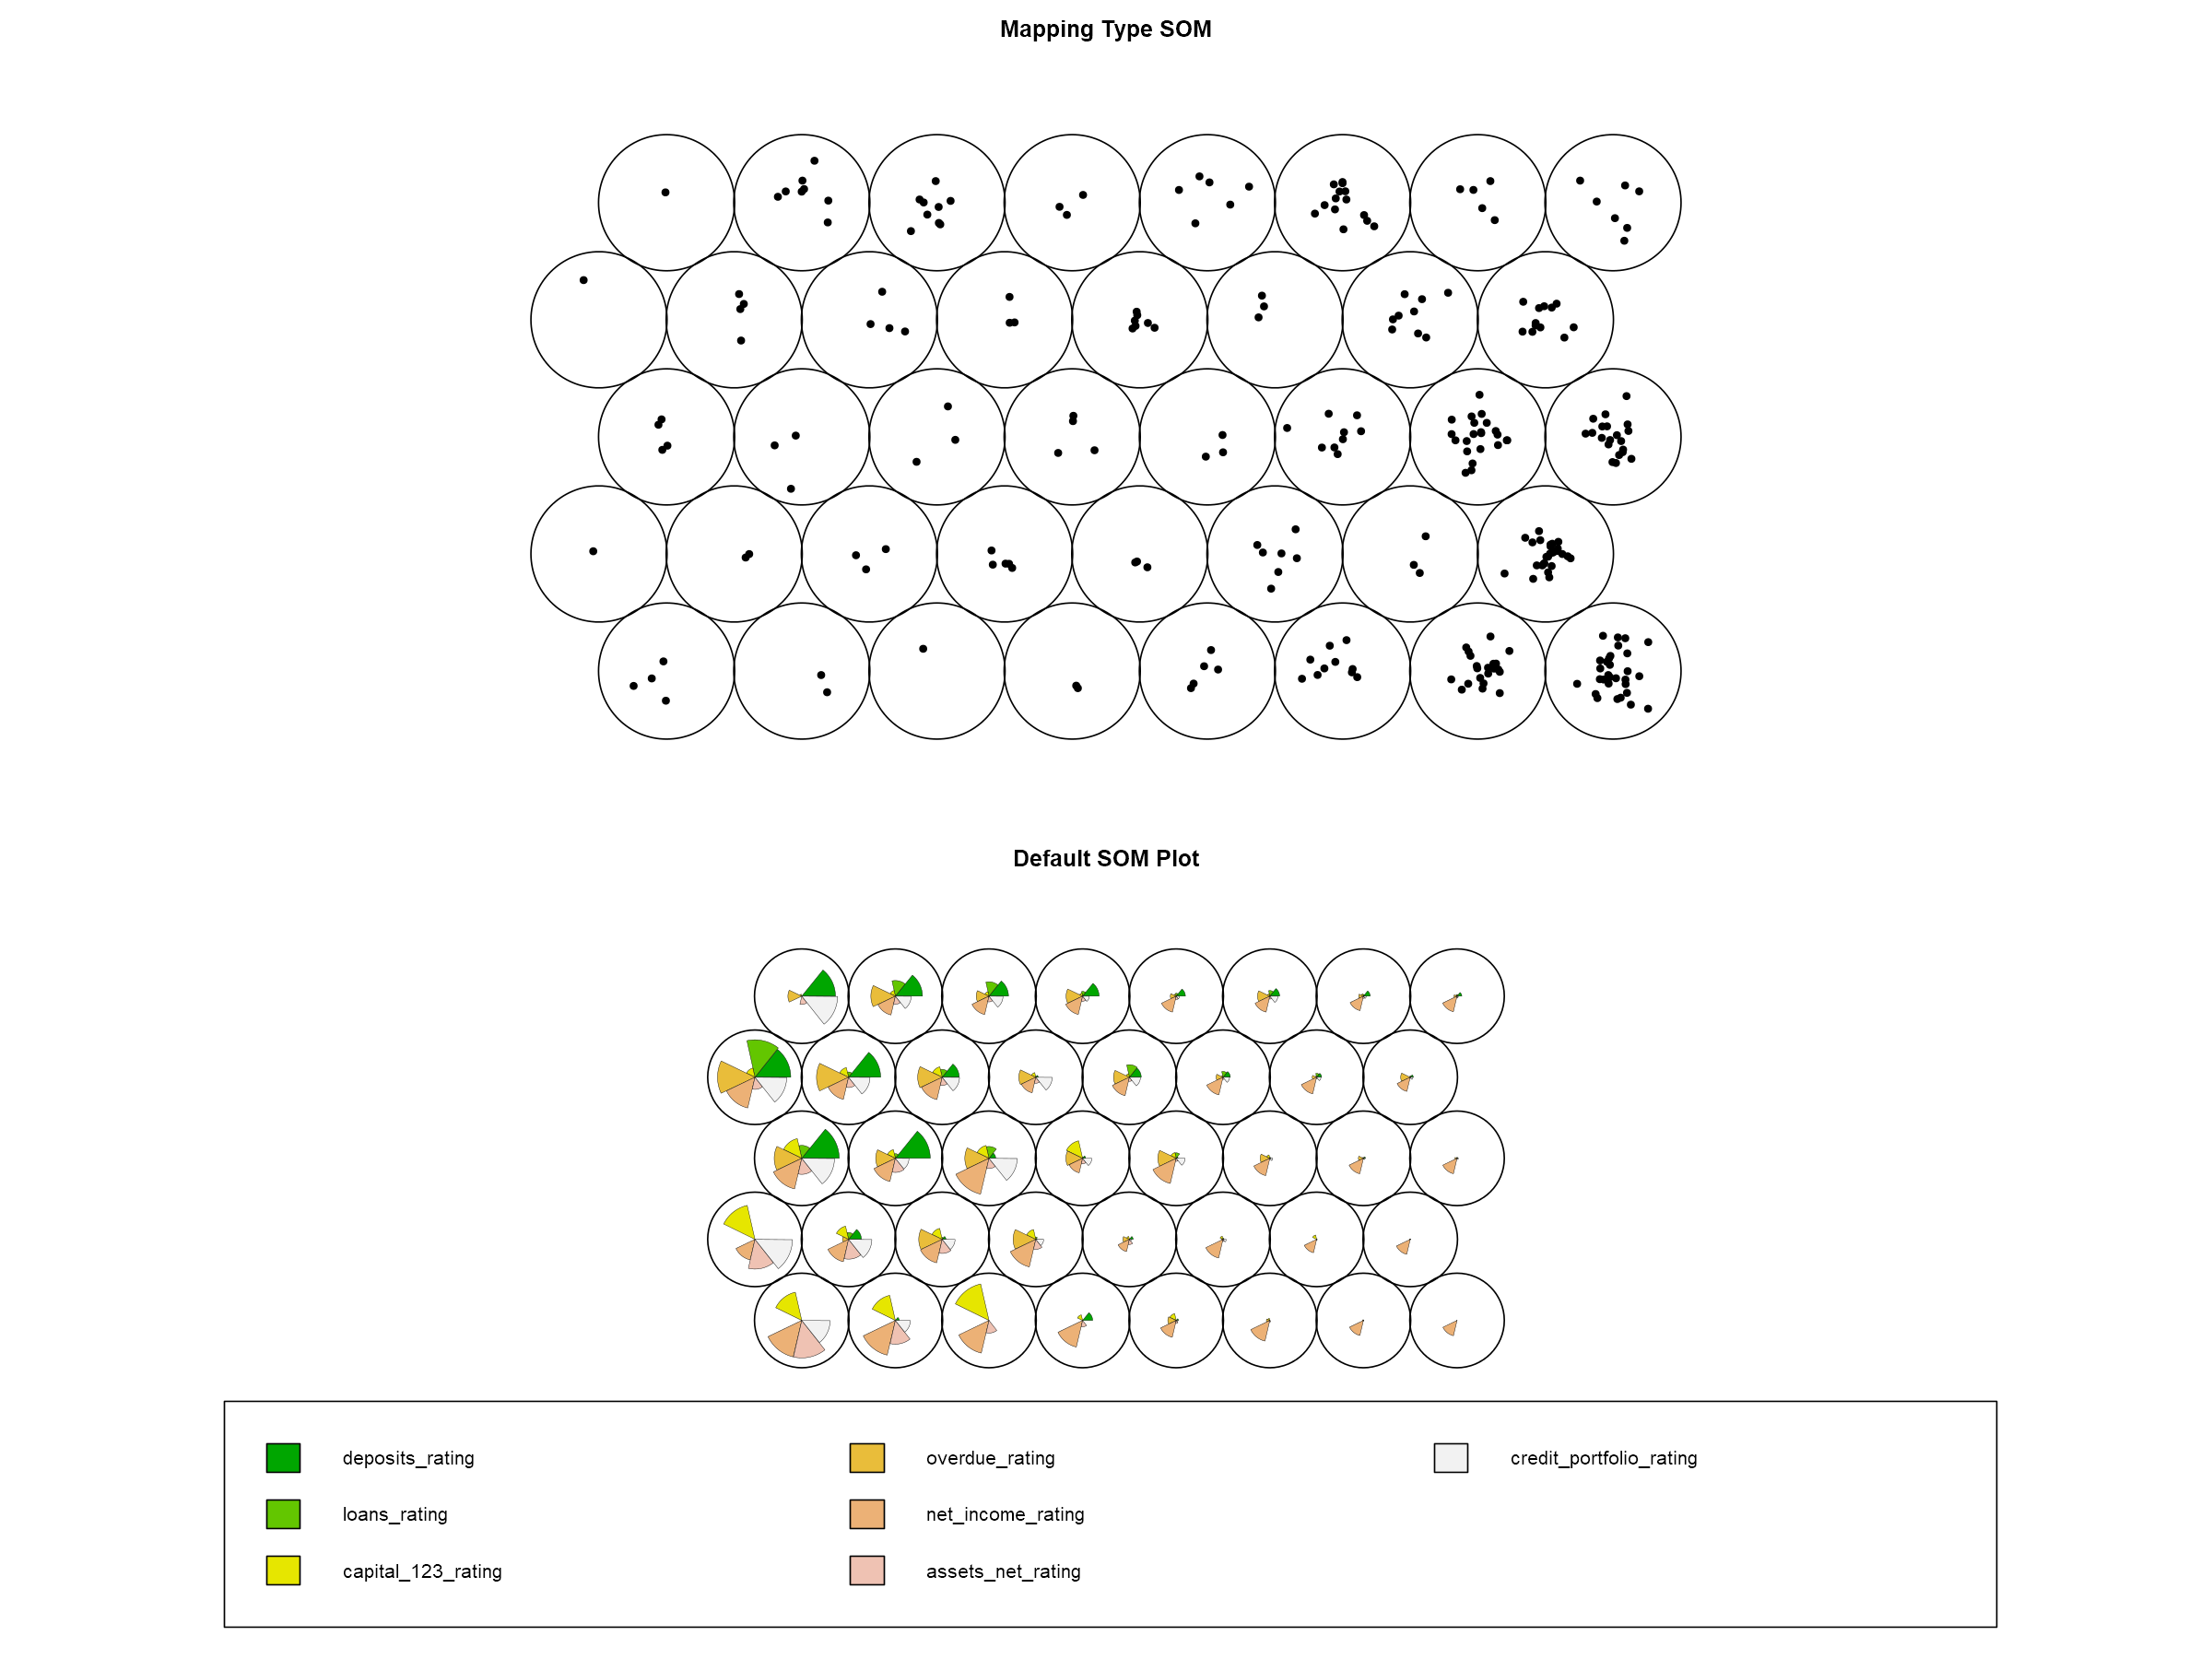

In [28]:
# Weight Vector View
par(mfrow = c(2, 1))
plot(som_model, type = "mapping", pchs = 20, main = "Mapping Type SOM")
plot(som_model, main = "Default SOM Plot")

#### Все нейроны оказалась заполнены - размер сетки подобран правильно. 
#### Видно, что в правом верхнем углу оказались банки с наибольшим значением объема депозитов, кредитов, просрочки и чистой прибыли. В правый нижний угол банки отбирались в основном на основе объема чистых активов, капитала, портфеля кредитов и чистой прибыли. В левом верхнем углу отбор банков в большей степени объясняля их бизостью по просрочке.

#### Построим тепловую карту Кохонена

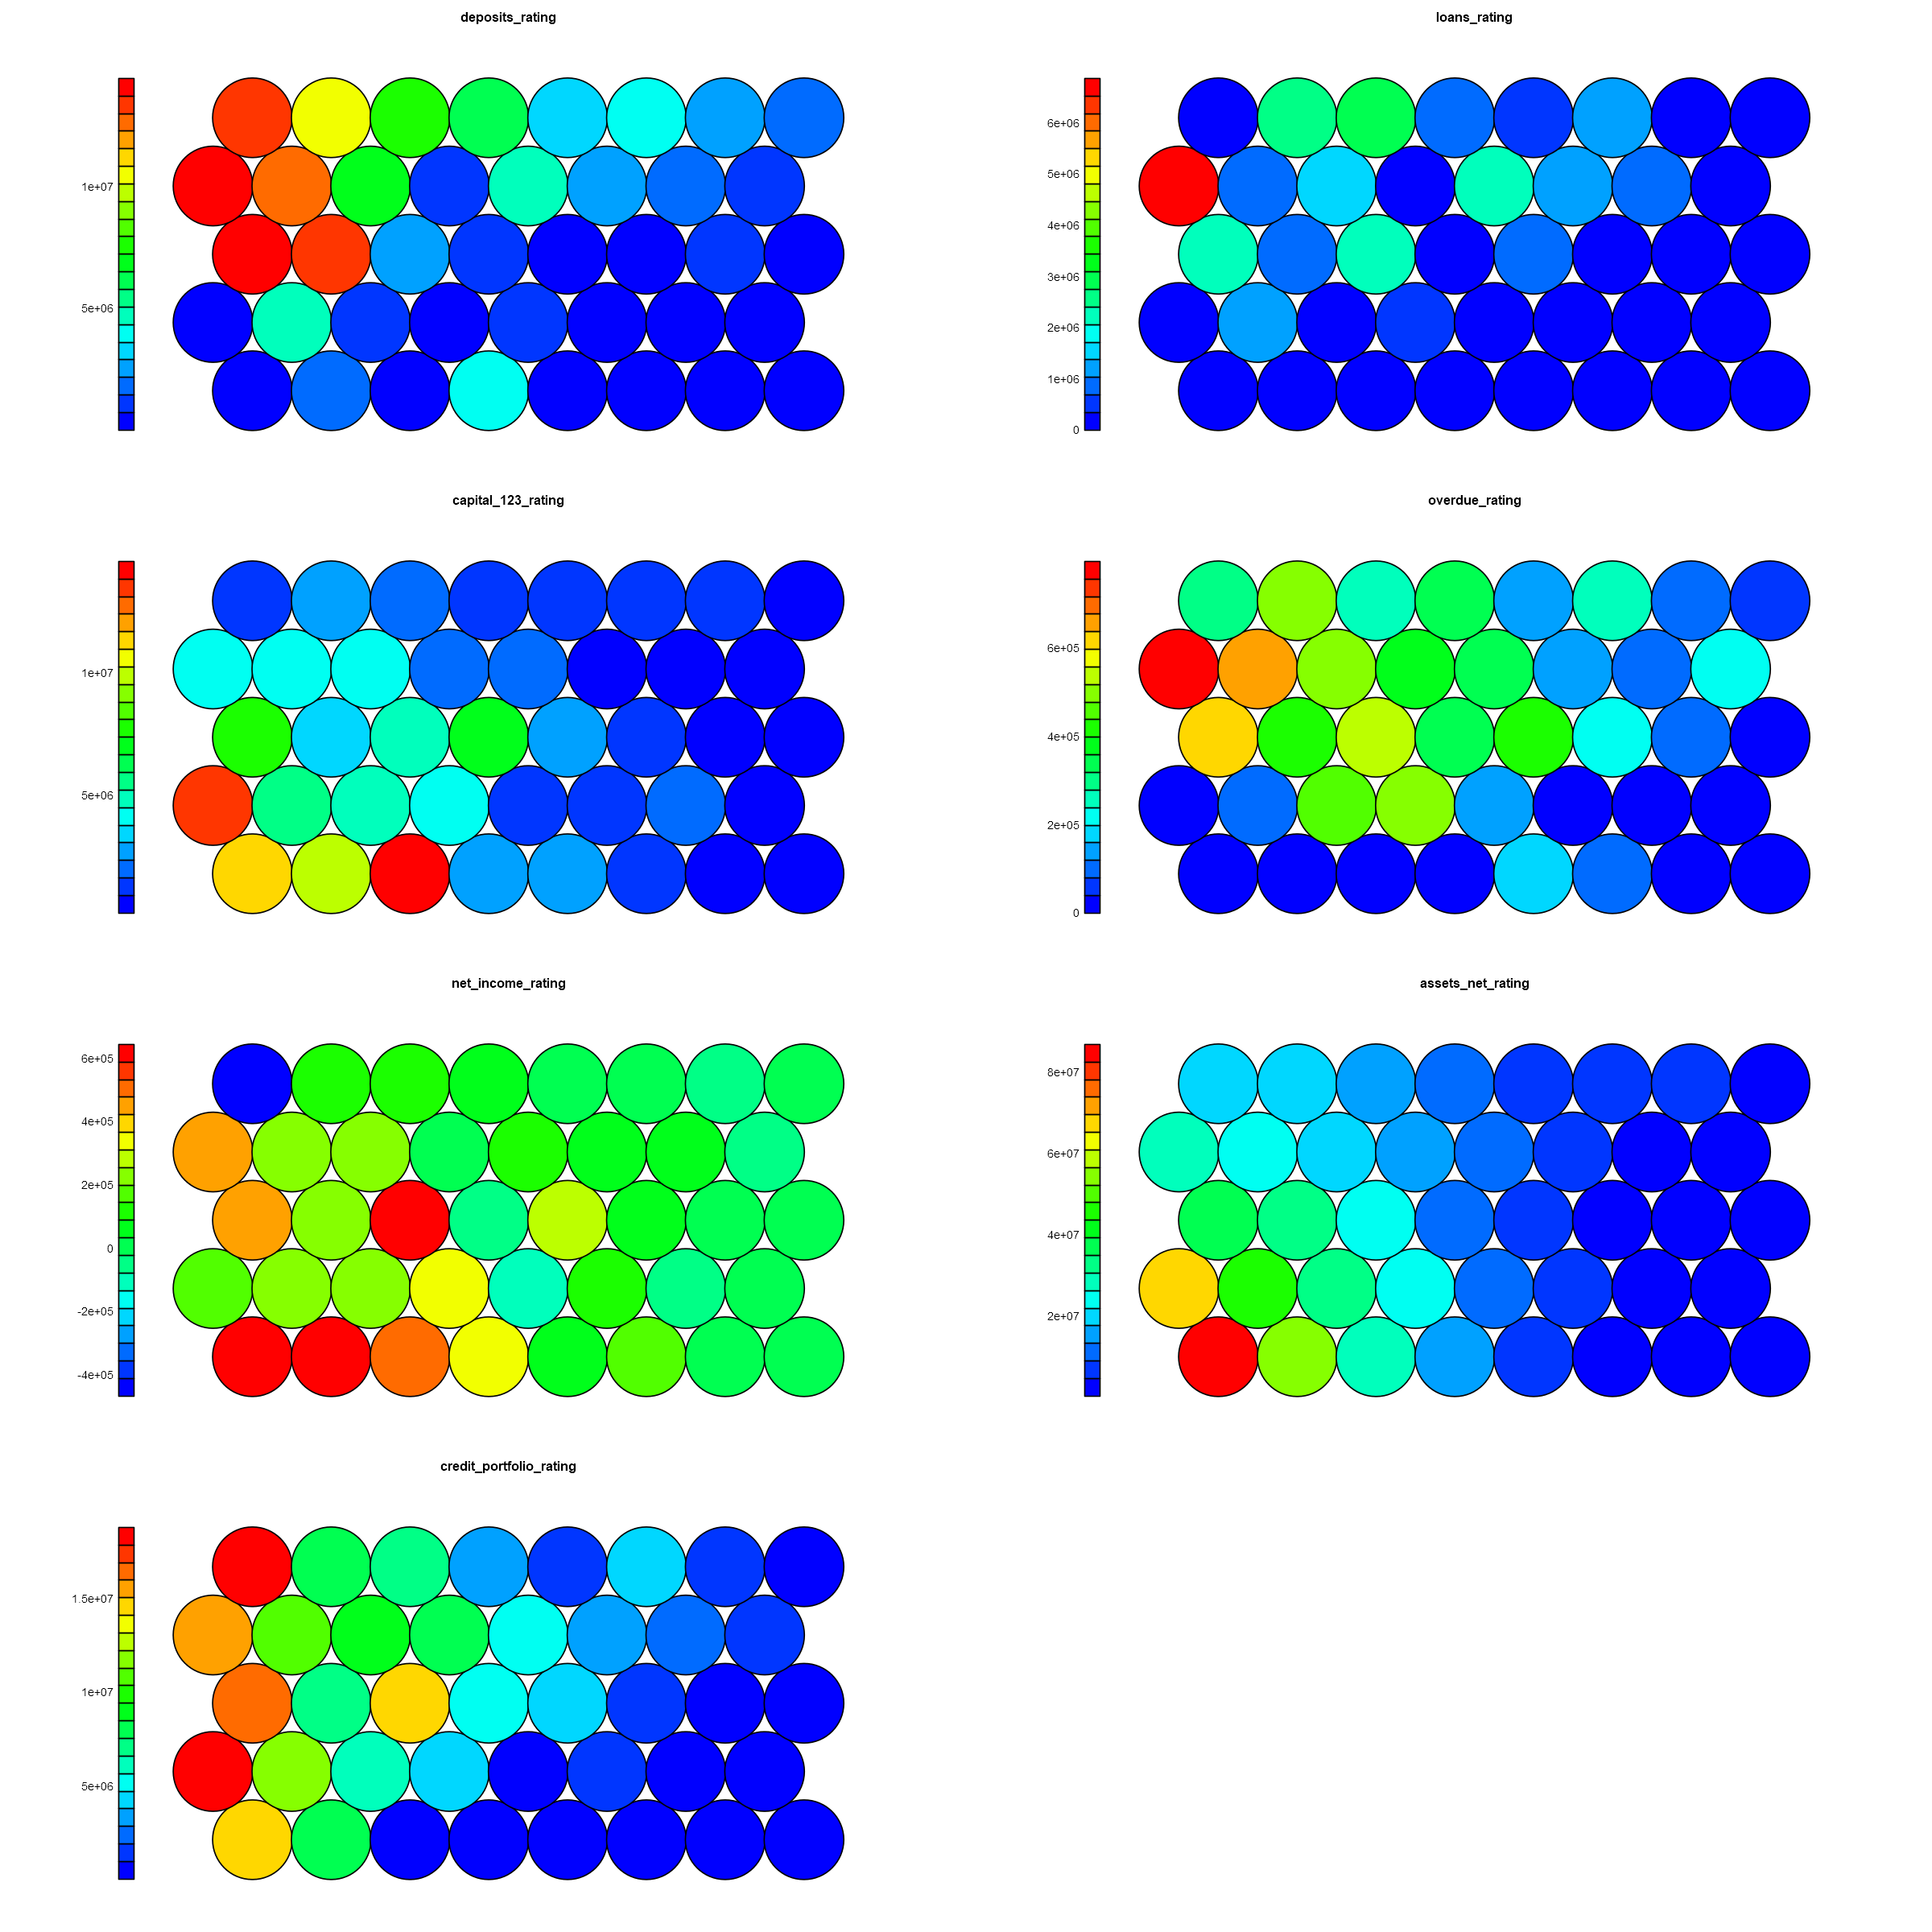

In [29]:
# Kohonen Heatmap для ненормированных исходных данных
options(repr.plot.width=20, repr.plot.height=20)
coolBlueHotRed <- function(n, alpha = 1) {
    rainbow(n, end=4/6, alpha=alpha)[n:1]
}


par(mfrow = c(4, 2))
for (p in 1:7){
    var_unscaled <- aggregate(as.numeric(data_train[,p]),
                              by=list(som_model$unit.classif), FUN=mean, 
                              simplify=TRUE)[,2] 
    plot(som_model,
         type = "property", 
         property=var_unscaled, 
         main=colnames(getCodes(som_model))[p],
         palette.name=coolBlueHotRed)
    }

#### Приведенная выше визуализаця с помощью тепловых карт подтверждает описанные выше критерии распределения банков по областям карты. Видно, что банки с наибольшим объемом просрочки и наибольшим объемом капитала оказались в полярных частях карты. Аналогичная "обратная зависимость" заметна также для пары признаков кредиты и просроченная задолженность (хотя, она не так заметна). Кроме того, видно, что чистая прибыль банка меньше всего коррелирует с остальными признаками.

##### Нейроны карты Кохонена можно также кластеризовать - выделить изолированные группы со схожими метриками (на основе распределений значений вокруг центров кластеров). Оптимальное число кластеров может быть выявлено с помощью алгоритма k-средних и оценки суммы квадратов расстояний между наблюдениями внутри кластеров.

integer(0)

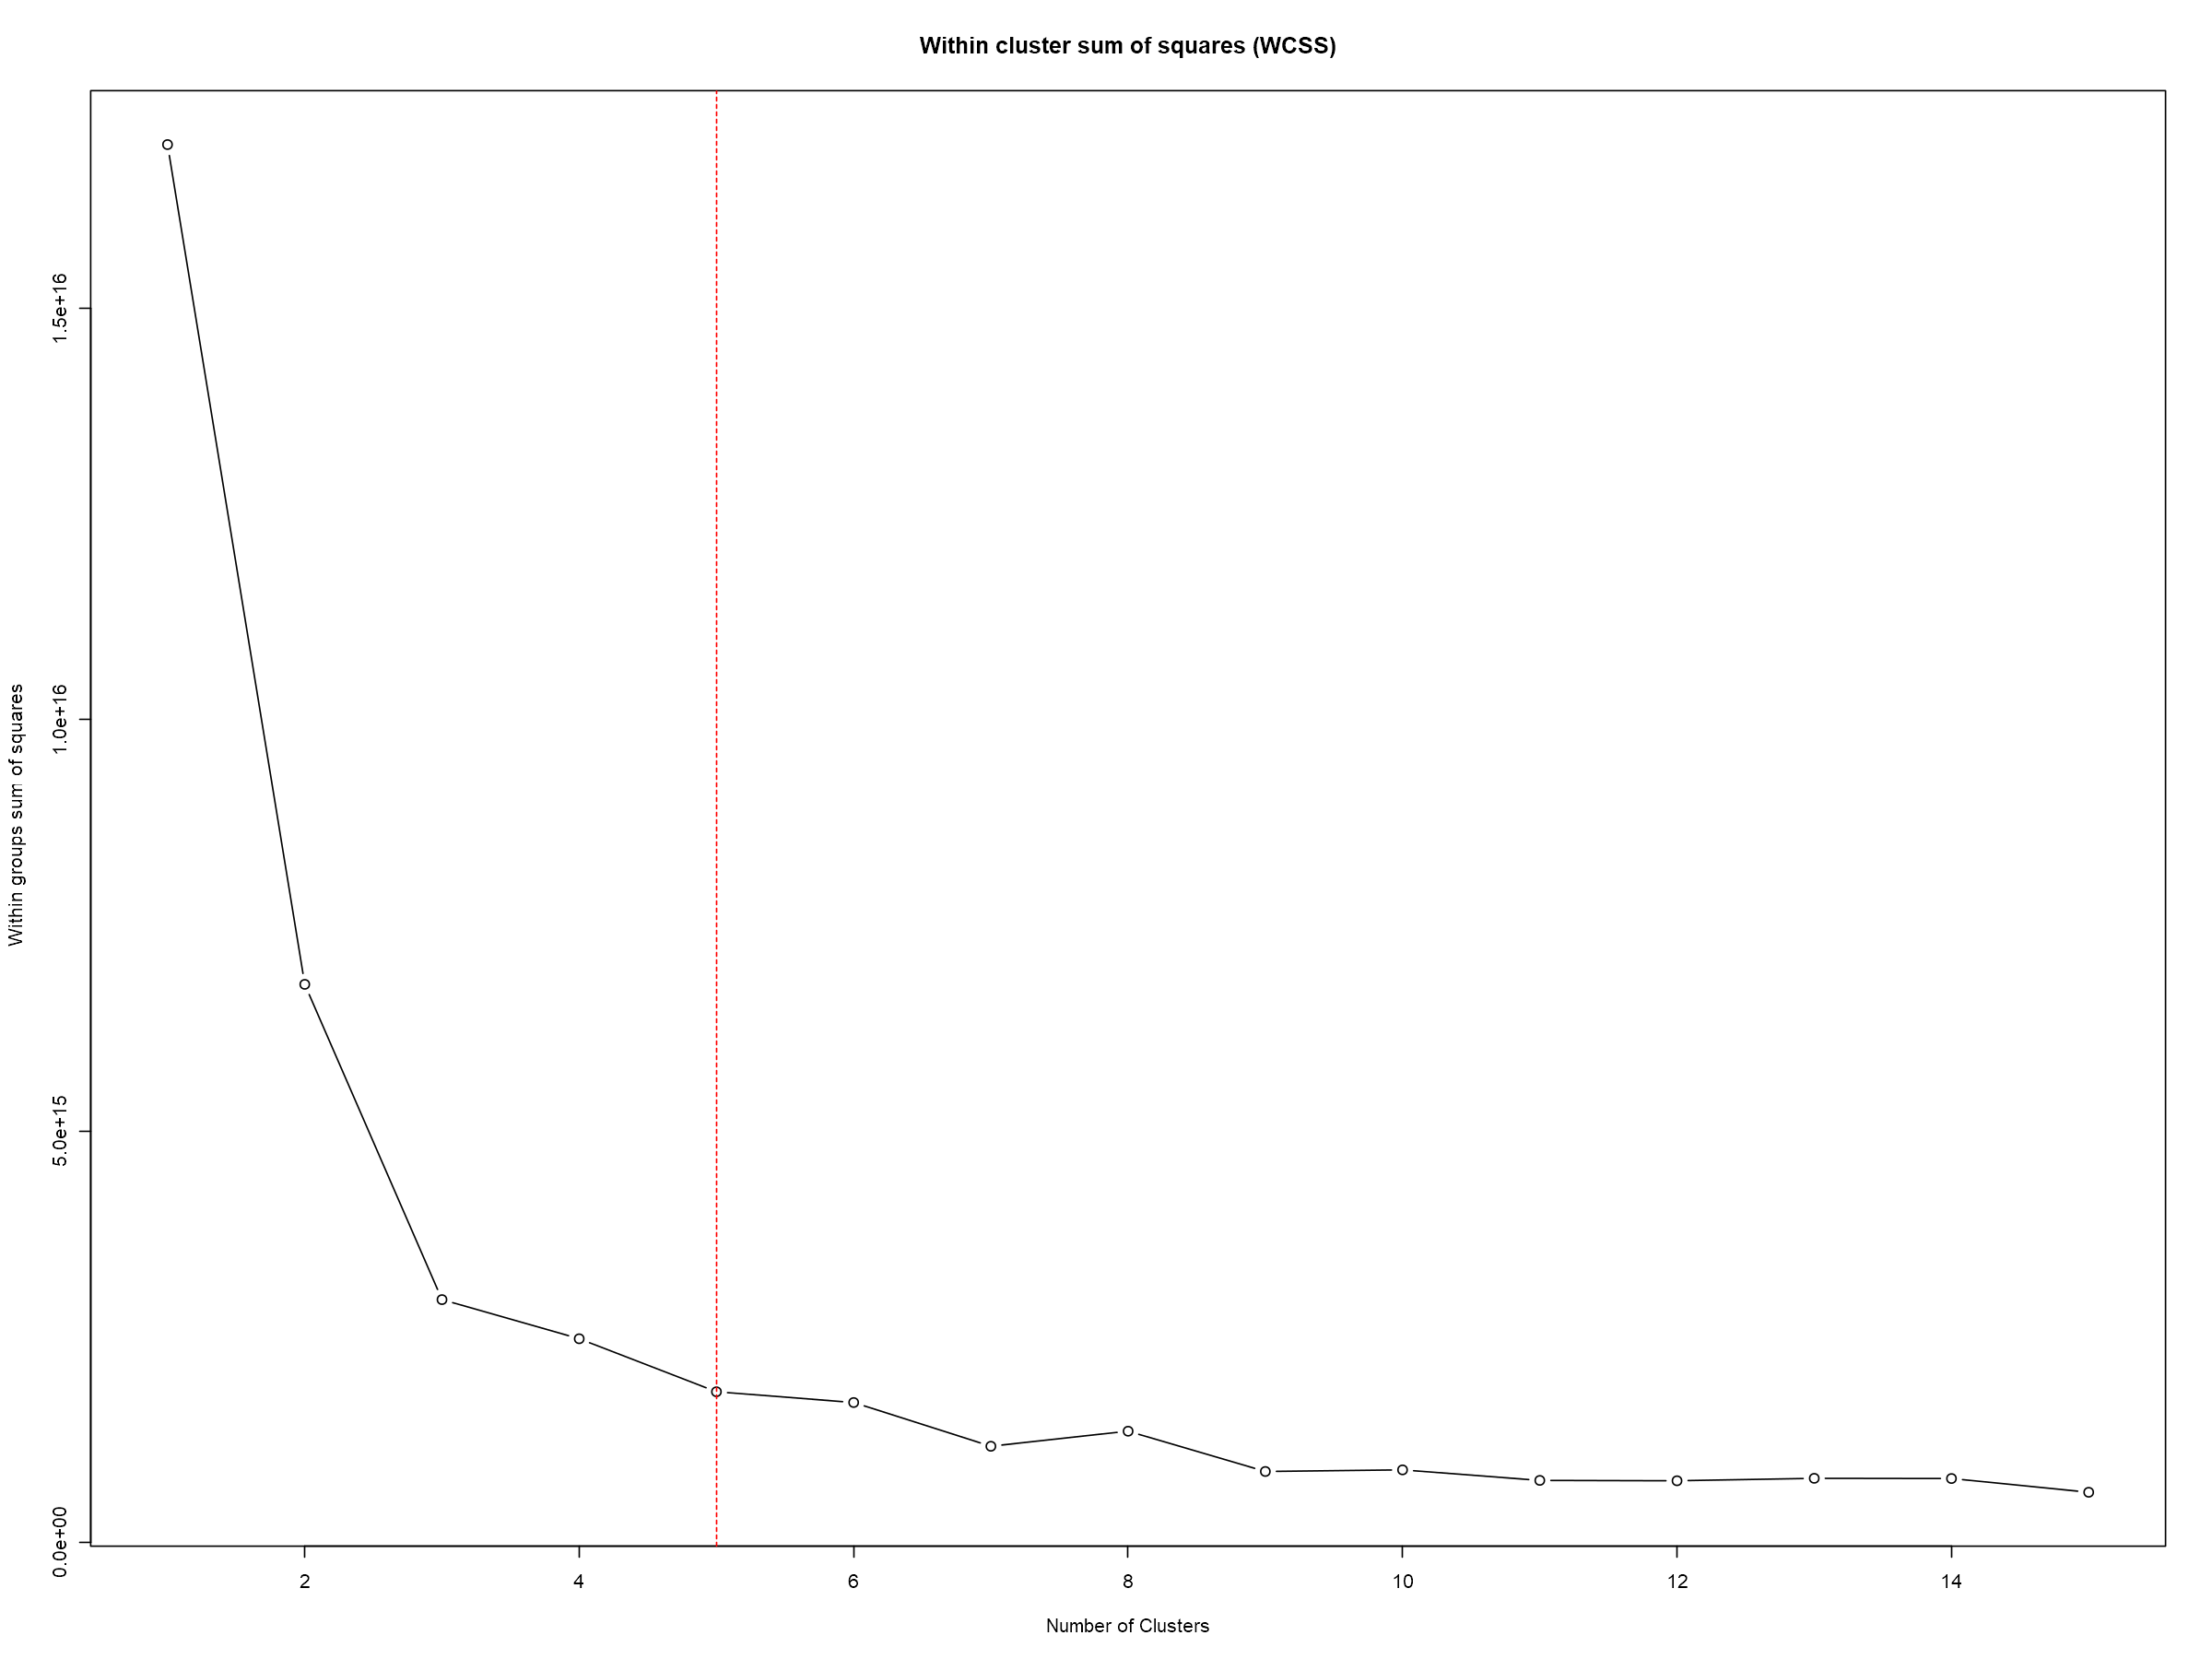

In [30]:
#Clustering SOM
#Посмотрим на метрику WCSS для определения оптимального числа кластеров с помощью k-средних
options(op)
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
set.seed(2020)
for (i in 2:15){
    wss[i] <- sum(kmeans(mydata,
                         centers=i)$withinss)}
par(mar=c(5.1,4.1,4.1,2.1))
plot(1:15, wss, type="b", xlab="Number of Clusters",
     ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")+
    abline(v=5, col = 'red', lty =2)

#### По-видимому, выделяется 5 кластеров

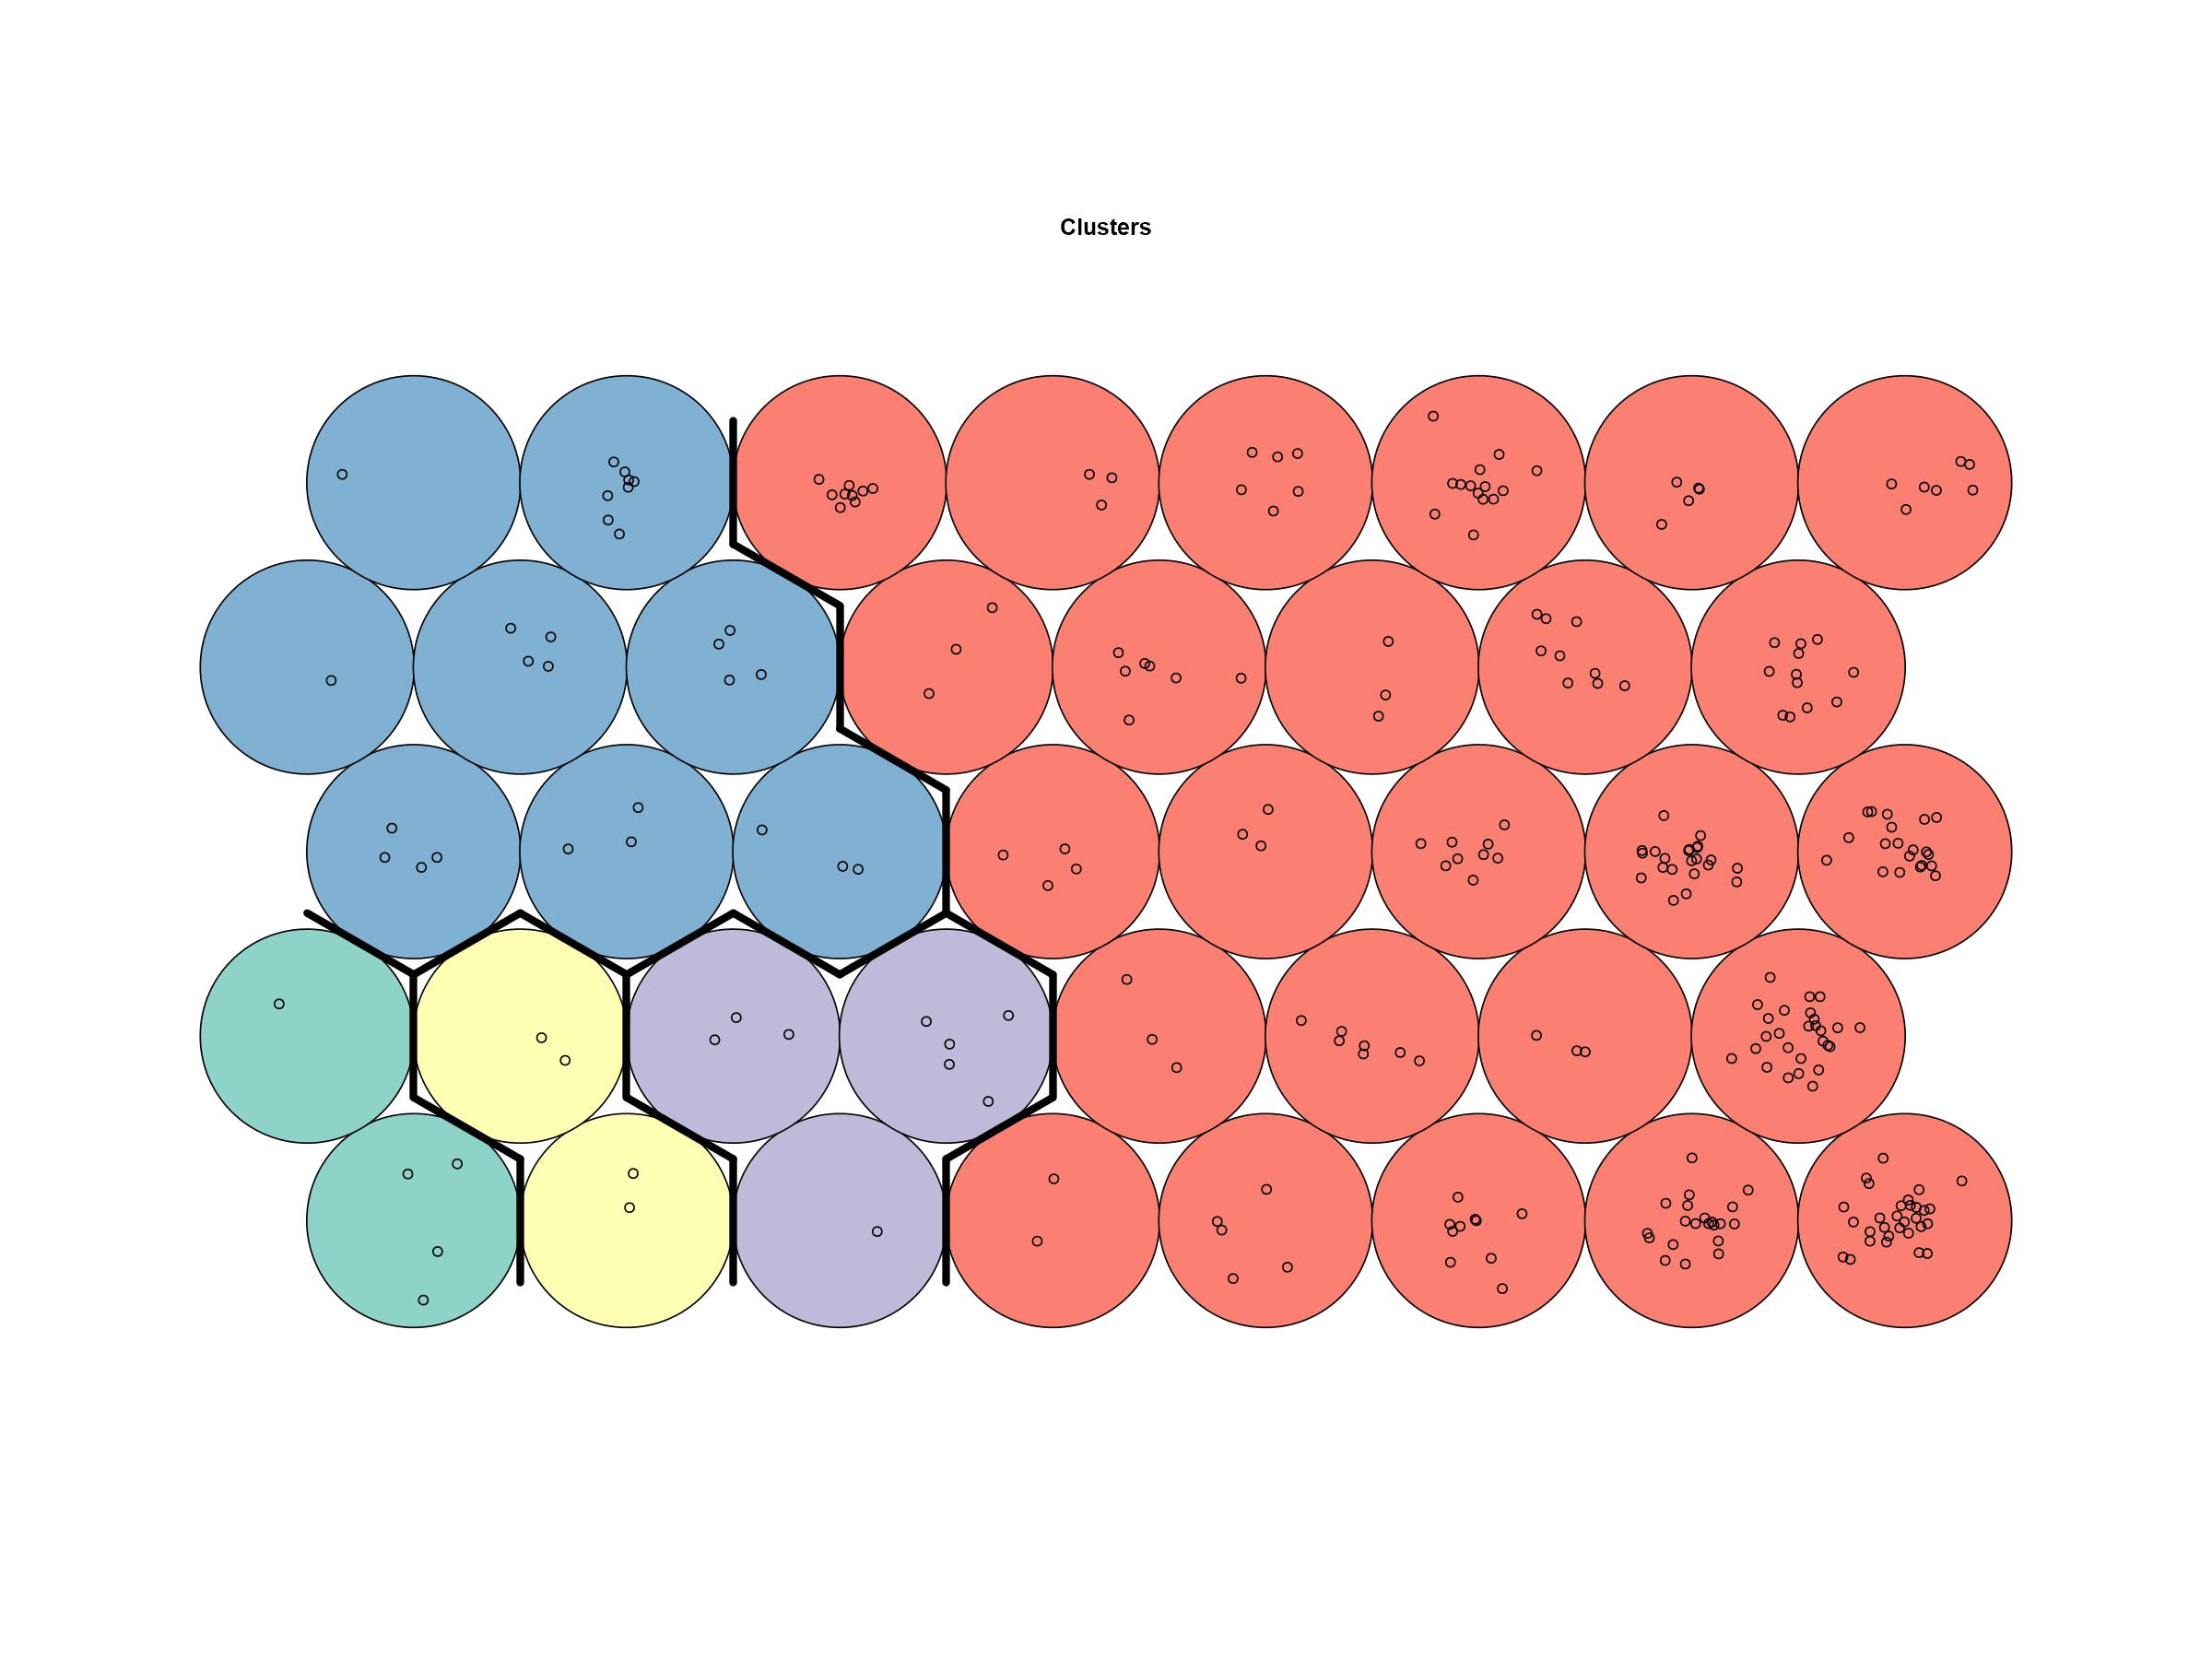

In [31]:
#используем иерархическую кластеризацию для выделения кластеров на карте Кохонена
options(repr.plot.width=20, repr.plot.height=15)
pretty_palette <- brewer.pal(5, "Set3")
set.seed(2020)
som_cluster <- cutree(hclust(dist(getCodes(som_model))), 5)

plot(som_model, type="mapping", bgcol = pretty_palette[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

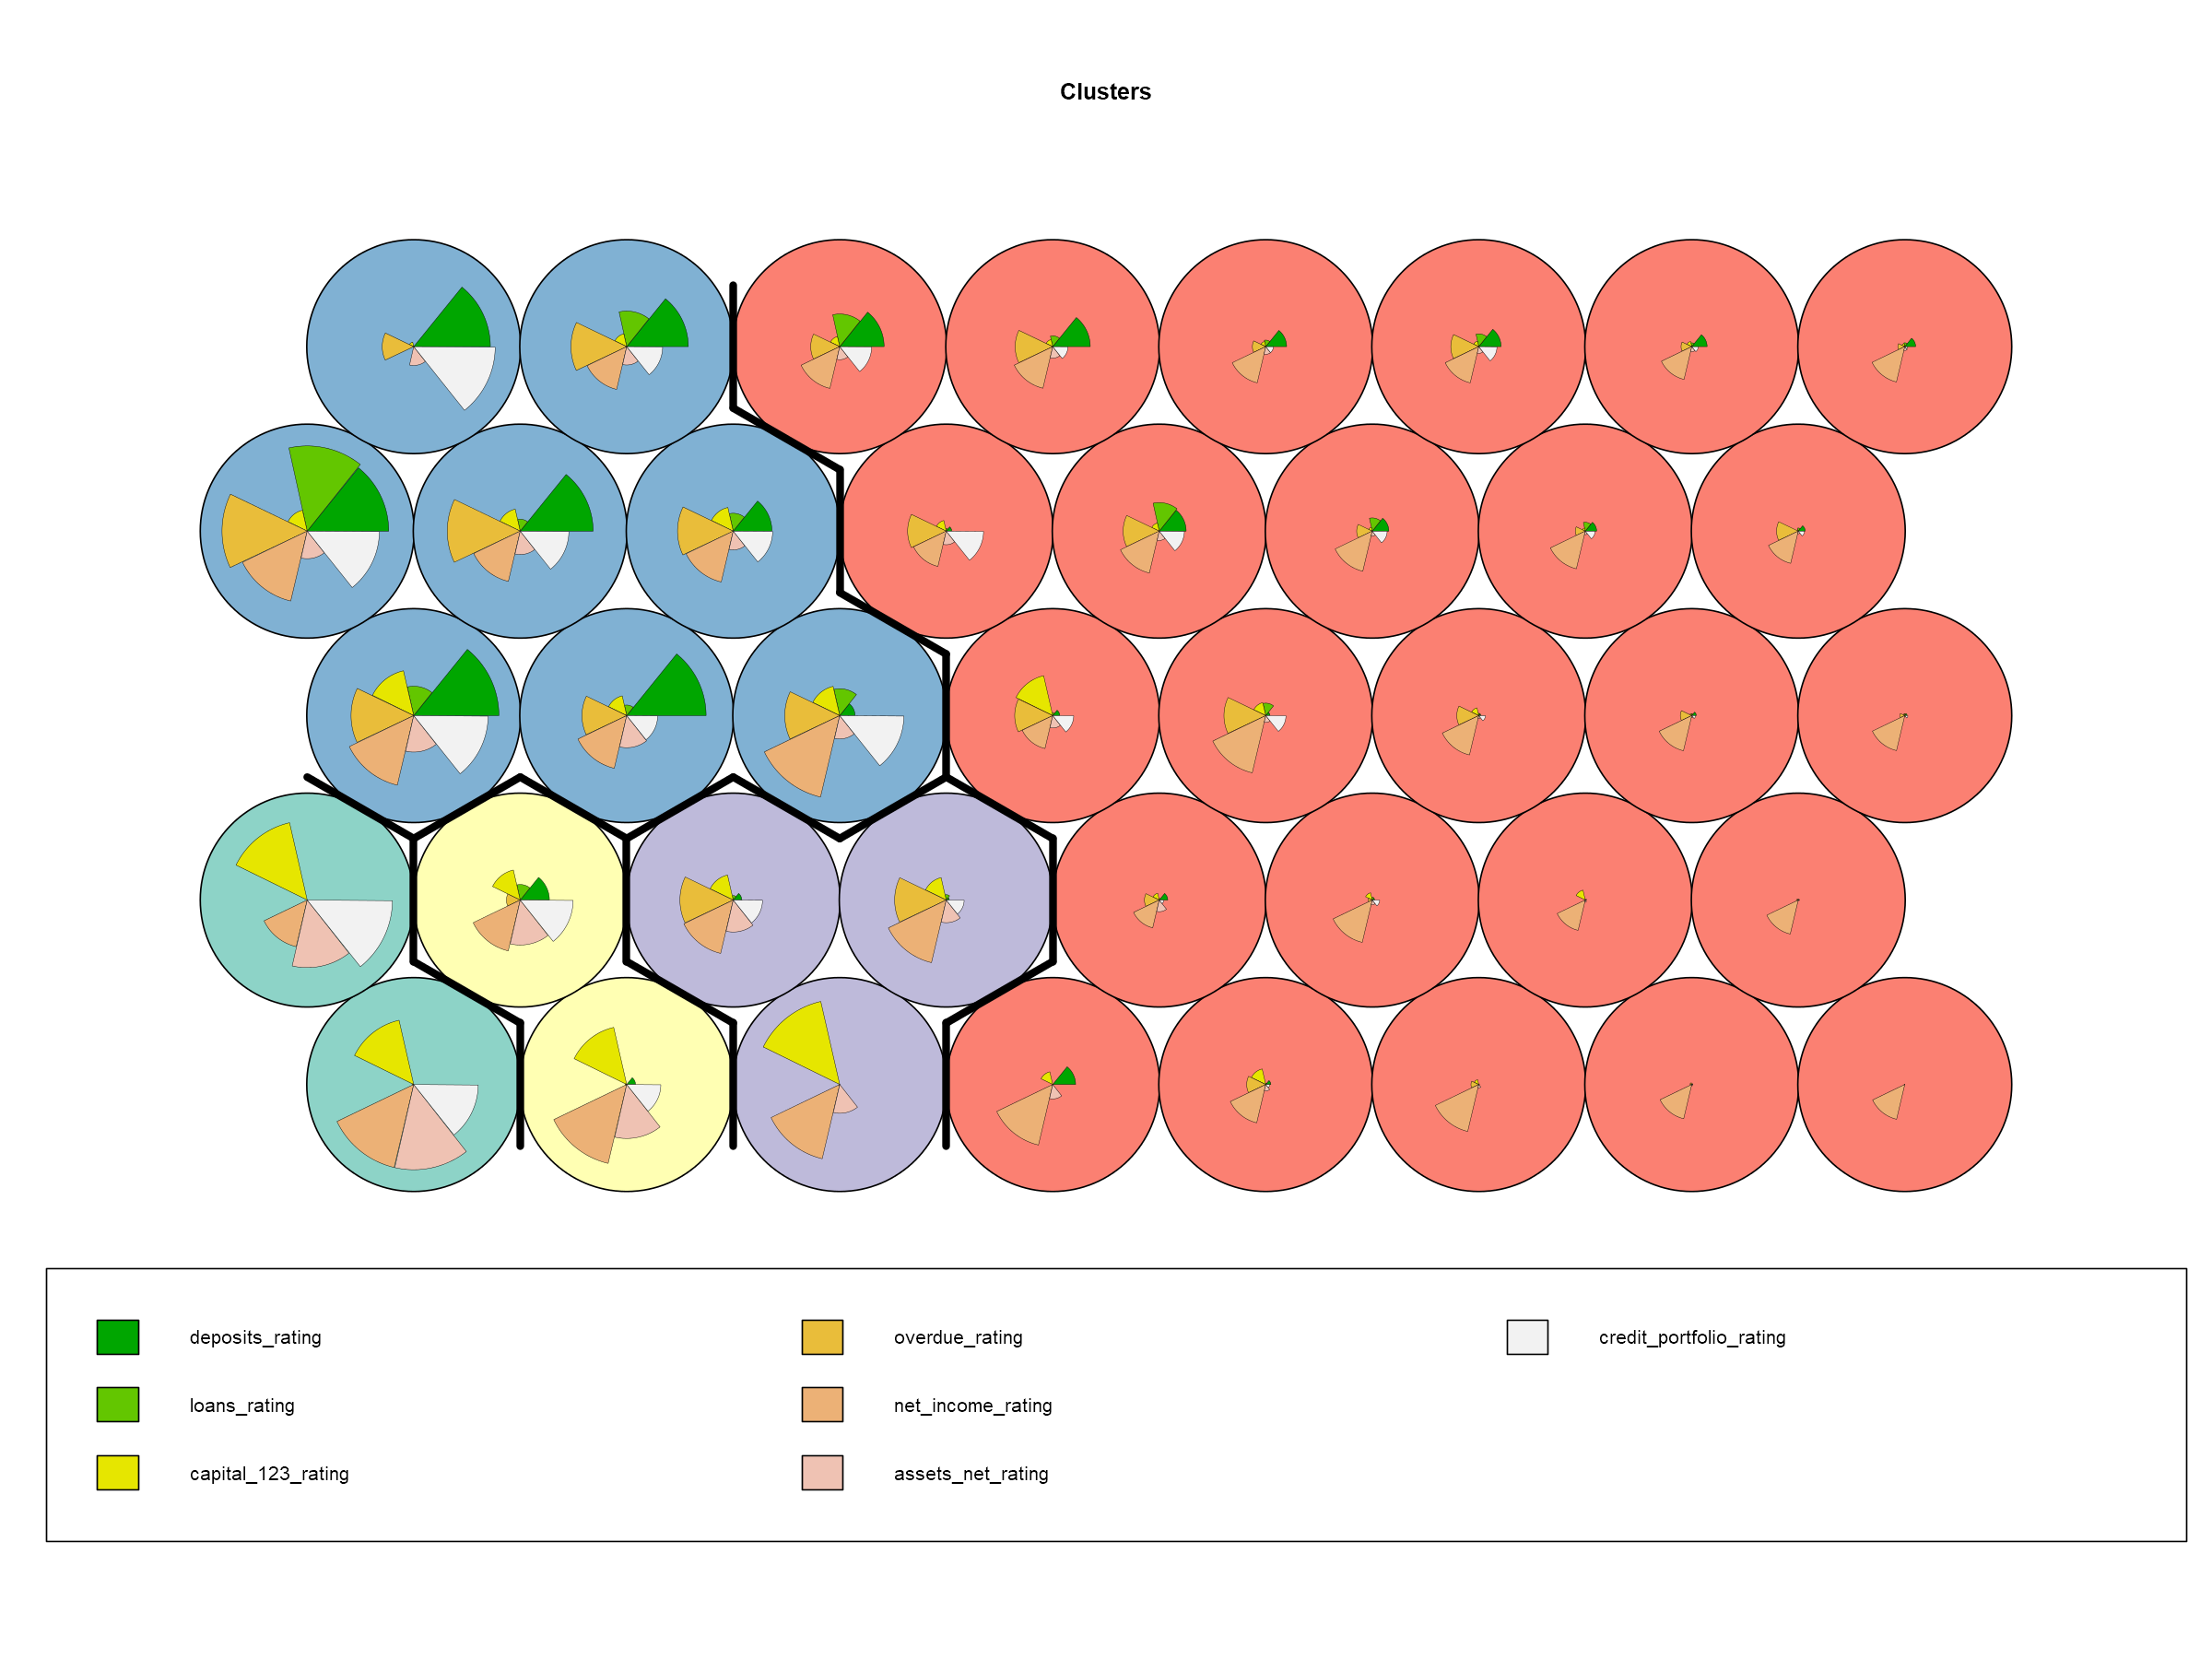

In [32]:
#Посмотрим также на распределение кодов
plot(som_model, type="codes", bgcol = pretty_palette[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

In [33]:
#ДОбавим номера кластеров к исходным данным
df_clust <- df
for (i in 4:10){
    df_clust <- remove_outliers(df_clust,i)
}
df_clust <- na.omit(df_clust)
cluster_assignment <- som_cluster[som_model$unit.classif]
df_clust$cluster <- cluster_assignment
df_clust[1:10,]

bank                    regnum region                 deposits_rating
81  Коммерцбанк (Евразия)   3333   Москва и обл.                 6       
82  Интерпрогрессбанк       600    Москва и обл.          17559859       
92  Креди Агриколь КИБ      1680   Санкт-Петербург и обл.      600       
93  Национальный Стандарт   3421   Москва и обл.          11734241       
94  Энергомашбанк           52     Санкт-Петербург и обл. 13011032       
95  Энергобанк              67     Татарстан               6265523       
98  Хлынов                  254    Кировская обл.         13837629       
100 Сумитомо Мицуи Рус Банк 3494   Москва и обл.                 0       
101 КЭБ ЭйчЭнБи Банк        3525   Москва и обл.                 0       
102 Денизбанк Москва        3330   Москва и обл.            393283       
    loans_rating capital_123_rating overdue_rating net_income_rating
81        0      11259731             32129         746210          
82  1919147       4660681           1211891         619892          
92        0      13543351                 0         161646          
93   402135      10316109            680239         155074          
94    45399        974321            293696        -466570          
95  2834980       5502722            973372         714748          
98  6872472       3793450            796701         474799          
100       0      17040042                 0         262318          
101    5000       4851123                 0         151244          
102     857       6305910                 0         403455          
    assets_net_rating credit_portfolio_rating cluster
81   84146206         21687636                1      
82   39894588         21484044                5      
92   68815686         18811776                1      
93   31843771         18144940                5      
94   19415818         18001953                5      
95   25439640         17532134                5      
98   28311638         15935214                5      
100 103254135         15257550                1      
101  44987751         14873511                2      
102  23768162         14844554                5

In [37]:
paste(c("Banks from the 1st cluster: ", df_clust[df_clust$cluster==1,]$bank), collapse=', ')
paste(c("Banks from the 2nd cluster: ", df_clust[df_clust$cluster==2,]$bank), collapse=', ')
paste(c("Banks from the 3rd cluster: ", df_clust[df_clust$cluster==3,]$bank), collapse=', ')
paste(c("Banks from the 4th cluster: ", df_clust[df_clust$cluster==4,]$bank), collapse=', ')
paste(c("Banks from the 5th cluster: ", df_clust[df_clust$cluster==5,]$bank), collapse=', ')

[1] "Banks from the 1st cluster: , Коммерцбанк (Евразия), Креди Агриколь КИБ, Сумитомо Мицуи Рус Банк, СЭБ Банк, Эйч-Эс-Би-Си Банк (HSBC)"

[1] "Banks from the 2nd cluster: , КЭБ ЭйчЭнБи Банк, Энерготрансбанк, БНП Париба Банк, Бэнк оф Чайна"

[1] "Banks from the 3rd cluster: , Аресбанк, Тольяттихимбанк, Ури Банк, Чайна Констракшн, Автоторгбанк, Натиксис Банк, Модульбанк, Консервативный Коммерческий Банк, Банк Кредит Свисс"

[1] "Banks from the 4th cluster: , Гарант-Инвест, Форштадт, КС Банк, НИКО-Банк, Национальная Факторинговая Компания, Банк Казани, Юг-Инвестбанк, Банк БКФ, Руснарбанк, Датабанк, Томскпромстройбанк, Нацинвестпромбанк, Национальный Резервный Банк, Банк Жилищного Финансирования, Банк Сберегательно-Кредитного Сервиса, Ишбанк, Зираат Банк, Хакасский Муниципальный Банк, Нефтепромбанк, Трансстройбанк, Актив Банк, Ростфинанс, Екатеринбург, Солид Банк, Славия, Промтрансбанк, Чайнасельхозбанк, Сибсоцбанк, Сити Инвест Банк, Газтрансбанк, Кузнецкий, Банк Оранжевый, Автоградбанк, НОКССбанк, Земский Банк, Венец, ФорБанк, Стройлесбанк, Мегаполис, Ставропольпромстройбанк, Снежинский, Кузнецкбизнесбанк, Белгородсоцбанк, Алтайкапиталбанк, ЮМК Банк, Индустриальный Сберегательный Банк, Енисейский Объединенный Банк, Владбизнесбанк, Русьуниверсалбанк, Камский Коммерческий Банк, Углеметбанк, Первый Клиентский Банк, Кетовский Коммерческий Банк, Итуруп, Агророс, Первоуральскбанк, Тендер-Банк, Братский АНКБ, СИАБ, Муниципальный Камчатпрофитбанк, Синко-Банк, Яринтербанк, Вологжанин, БСТ-Банк, Веста, Северный Народный Банк, Элита, Банк Раунд, Унифондбанк, Гута-Банк, Кубаньторгбанк, Профессионал Банк, Банк Кремлевский, Азия-Инвест Банк, Крокус-Банк, Международный Коммерческий Банк, Новый Век, Система, Новобанк, Первый Инвестиционный Банк, Москва-Сити, РБА, Газнефтьбанк, Проинвестбанк, Живаго Банк, Нейва, Севастопольский Морской Банк, Объединенный Резервный Банк, Кузбассхимбанк, Приобье, Современные Стандарты Бизнеса, Банк Заречье, АвтоКредитБанк, Евроазиатский Инвестиционный Банк, Долинск, Альба Альянс, Тамбовкредитпромбанк, Банк Глобус, Уралпромбанк, Банк Пермь, Черноморский банк развития и реконструкции, Крона-Банк, Россита-Банк, Ермак, Майкопбанк, Тексбанк, Платина, Костромаселькомбанк, Викинг, Новый Московский Банк, Саратов, ИРС, Витабанк, Донкомбанк, Калуга, Арзамас, Примтеркомбанк, Саммит Банк, Социум-Банк, ЕАТП Банк, Экси-Банк, Заубер Банк, Новокиб, Классик Эконом Банк, Горбанк, Америкэн Экспресс Банк, Банк РМП, Первый Дортрансбанк, Байкалкредобанк, Руна-Банк, Республиканский Кредитный Альянс, Соколовский, Курган, Роял Кредит Банк, Спецстройбанк, Евроальянс, Финам Банк, Коммерческий Индо Банк, Йошкар-Ола, Русский Банк Сбережений, Мурманский Социальный Коммерческий Банк, Почтобанк, Столичный Кредит, Великие Луки Банк, МТИ Банк, Прокоммерцбанк, Нальчик, Балаково-Банк, Московский Коммерческий Банк, Алтынбанк, Евразийский Банк, Химик, ИТ Банк, Кросна-Банк, Космос, Торжок (бывш. Торжокуниверсалбанк), Промсельхозбанк, Национальный Банк Сбережений, Максима, Агора, Спутник, Банк Стандарт-Кредит, Славянбанк, Ноосфера, Внешфинбанк, Таганрогбанк, Северстройбанк, Сельмашбанк, Вакобанк, Гефест, Дон-Тексбанк, Объединенный Банк Республики, РФИ Банк, Юнистрим, Санкт-Петербургский Банк Инвестиций, Дружба, Народный Инвестиционный Банк, Тайдон, ФинТех, МВС Банк, Уралфинанс, Континенталь, Икано Банк, Лэнд Кредит, ИК Банк, Банк Берейт, Народный Доверительный Банк, Альтернатива, Земкомбанк, Сервис Резерв, Банк РСИ, РусьРегионБанк, Бест Эффортс Банк, Дом-Банк, Рента-Банк, Онего, Банк Фридом Финанс, Ю Би Эс Банк, Далена Банк, Вятич, Оней Банк, Промсвязьинвест, Капитал, Холмск, Банк ПСА Финанс Рус, РЕСО Кредит, Эко-Инвест, Вестерн Юнион ДП Восток, Инкахран, Севзапинвестпромбанк, Геобанк, Элекснет, Финчер, Акрополь, Мурманский Расчетный Центр, Деньги.Мэйл.Ру, Премиум, Перспектива, Р-Инкас, Металлург, Единая Расчетная Палата, Вкабанк, Банк 131, Глобал Эксчейндж, Дальний Восток, Единая касса, Инэко, Красноярский Краевой Расчетный Центр, Межбанковский Кредитный Союз, Моби.Деньги, Монета.ру, Нарат, Петербургский Расчетный Центр, Платежи и Расчеты, Платежный Стандарт, ПэйПал Ру, ПэйЮ, Расчетные Решения, РИБ, Русское Финансовое Общество, Сетевая Расчетная Палата, Синергия, Электронный платежный сервис, Элплат"

[1] "Banks from the 5th cluster: , Интерпрогрессбанк, Национальный Стандарт, Энергомашбанк, Энергобанк, Хлынов, Денизбанк Москва, Саровбизнесбанк, Татсоцбанк, НБД-Банк, Росдорбанк, Реалист Банк, Развитие-Столица, НС Банк, Банк Оренбург, Инбанк, Акибанк, Банк Акцепт, Морской Банк, Прио-Внешторгбанк, Алеф-Банк, Кошелев-Банк, Норвик Банк, НК Банк, Джей энд Ти Банк, Ланта-Банк, Александровский, Агропромкредит, Петербургский Социальный Коммерческий Банк"